# Diabetes Prediction: End-to-End Machine Learning Pipeline

This notebook presents a comprehensive workflow for diabetes prediction, including:

- Exploratory Data Analysis (EDA)
- Data Preprocessing & Feature Engineering
- Model Training (18+ models)
- Model Evaluation & Comparison
- Model Explainability & Interpretation
- Deployment Preparation


## Part 1: Setup & Exploratory Data Analysis


### Project Overview

This project demonstrates a professional machine learning pipeline for diabetes prediction using the Diabetes dataset. The workflow covers:

- In-depth EDA
- Data cleaning and transformation
- Feature engineering and selection
- Extensive model training and tuning
- Model evaluation and interpretation

### Project Structure

1. **Setup & Imports**
2. **Data Loading & Initial Inspection**
3. **Exploratory Data Analysis**
   - Univariate, Bivariate, Multivariate Analysis
   - Statistical Testing
4. **Data Preprocessing**
   - Missing Value Handling
   - Outlier Detection & Treatment
   - Feature Transformation
5. **Feature Engineering**
   - Feature Creation & Selection (RFECV)
   - Dimensionality Reduction (PCA)
6. **Train/Test Split & Class Imbalance Handling (SMOTE)**
7. **Model Development**
   - 15+ Algorithms
   - Hyperparameter Tuning
8. **Model Evaluation & Comparison**
9. **Feature Importance & Explainability (SHAP)**
10. **Model Saving & Deployment**
11. **Conclusion & Recommendations**

### 1. Setup & Imports

In [1]:
!pip install pandas>=1.3.0 \
              numpy>=1.19.0 \
              matplotlib>=3.4.0 \
              seaborn>=0.11.0 \
              scikit-learn>=1.0 \
              xgboost>=1.6.0 \
              catboost>=1.0.6 \
              shap>=0.39.0 \
              imbalanced-learn>=0.9 \
              nbformat>=5.1 \
              lightgbm>=3.0 \
              tensorflow>=2.6.0 \
              keras>=2.6.0 \
              scikit-optimize>=0.8.0 \
              yellowbrick>=1.3.0 \
              eli5>=0.11.0


In [2]:
import catboost


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, auc)
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

import joblib
import pickle

import shap
from eli5 import show_weights, explain_prediction

np.random.seed(42)

### 2. Data Loading & Initial Inspection

Load the Diabetes dataset and perform an initial exploration to understand its structure, features, and potential data quality issues.

In [4]:
df = pd.read_csv('/content/diabetes.csv')

print("First 5 rows of the dataset:")
display(df.head())

print(f"Dataset shape: {df.shape}")

print("\nColumn information:")
df.info()

First 5 rows of the dataset:


gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

Dataset shape: (100000, 9)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:

print("Statistical summary:")
display(df.describe())

print("\nMissing values in each column:")
display(df.isnull().sum())

print("\nActual column names in the dataframe:")
print(df.columns.tolist())

medical_cols = []
possible_columns = {
    'Glucose': ['glucose', 'Glucose', 'GLUCOSE'],
    'BloodPressure': ['bloodpressure', 'BloodPressure', 'blood_pressure', 'Blood Pressure', 'bp'],
    'SkinThickness': ['skinthickness', 'SkinThickness', 'skin_thickness', 'Skin Thickness'],
    'Insulin': ['insulin', 'Insulin', 'INSULIN'],
    'BMI': ['bmi', 'BMI', 'body_mass_index', 'Body Mass Index']
}

for standard_name, variations in possible_columns.items():
    found = False
    for variant in variations:
        if variant in df.columns:
            medical_cols.append(variant)
            found = True
            break
    if not found:
        print(f"Warning: Could not find a column matching '{standard_name}'")

print("\nZero values in medical columns (potential missing data):")
for col in medical_cols:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(df):.2%} of data)")

Statistical summary:


age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           140.000000       0.000000  
75%         6.200000           159.000000       0.000000  
max         9.000000           300.000000       1.000000


Missing values in each column:


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


Actual column names in the dataframe:
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Zero values in medical columns (potential missing data):
bmi: 0 zeros (0.00% of data)


Class distribution:


diabetes
0    91500
1     8500
Name: count, dtype: int64

<ipython-input-6-6484282b05b6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_column, data=df, palette='viridis')


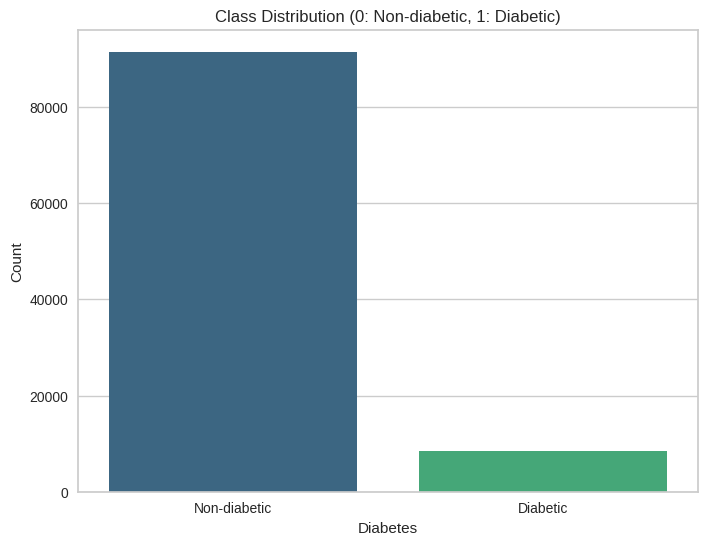

Imbalance ratio (Majority:Minority): 10.76:1


In [6]:
target_column = 'diabetes'

class_counts = df[target_column].value_counts()
print("Class distribution:")
display(class_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=df, palette='viridis')
plt.title('Class Distribution (0: Non-diabetic, 1: Diabetic)')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-diabetic', 'Diabetic'])
plt.show()

imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Imbalance ratio (Majority:Minority): {imbalance_ratio:.2f}:1")

### 3. Exploratory Data Analysis (EDA)

A thorough understanding of the data is essential before building predictive models. This section covers univariate, bivariate, and multivariate analyses to identify patterns, relationships, and potential issues.

#### 3.1 Univariate Analysis

Examine the distribution of each feature to understand central tendency, spread, and shape.

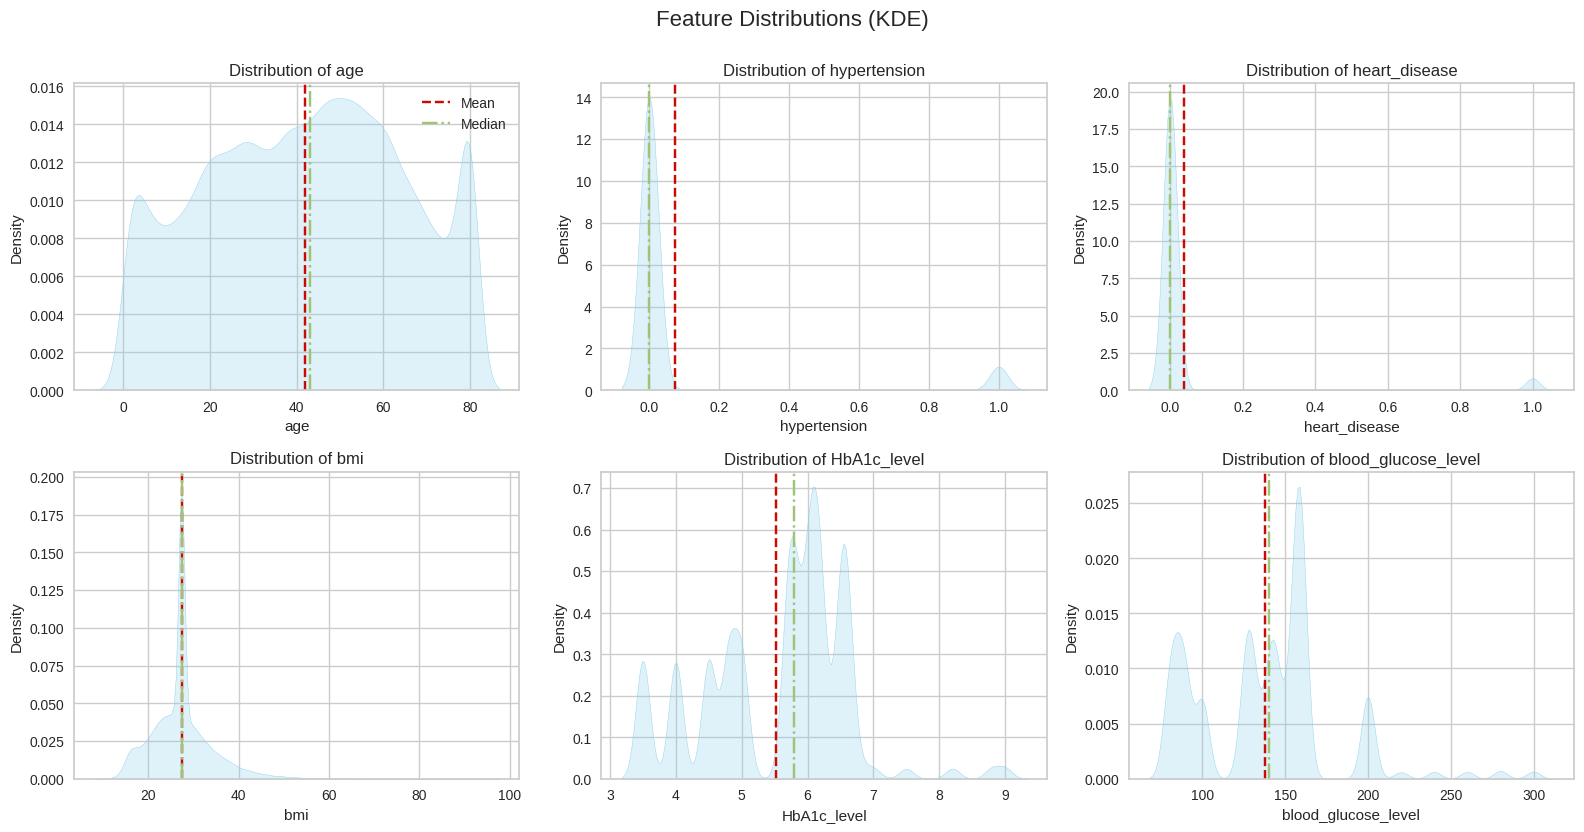

In [7]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.drop('diabetes')

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    ax = plt.subplot(3, 3, i+1)
    sns.kdeplot(data=df, x=col, fill=True, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.axvline(df[col].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(df[col].median(), color='g', linestyle='-.', label='Median')
    if i == 0:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions (KDE)', y=0.98, fontsize=16)
plt.show()

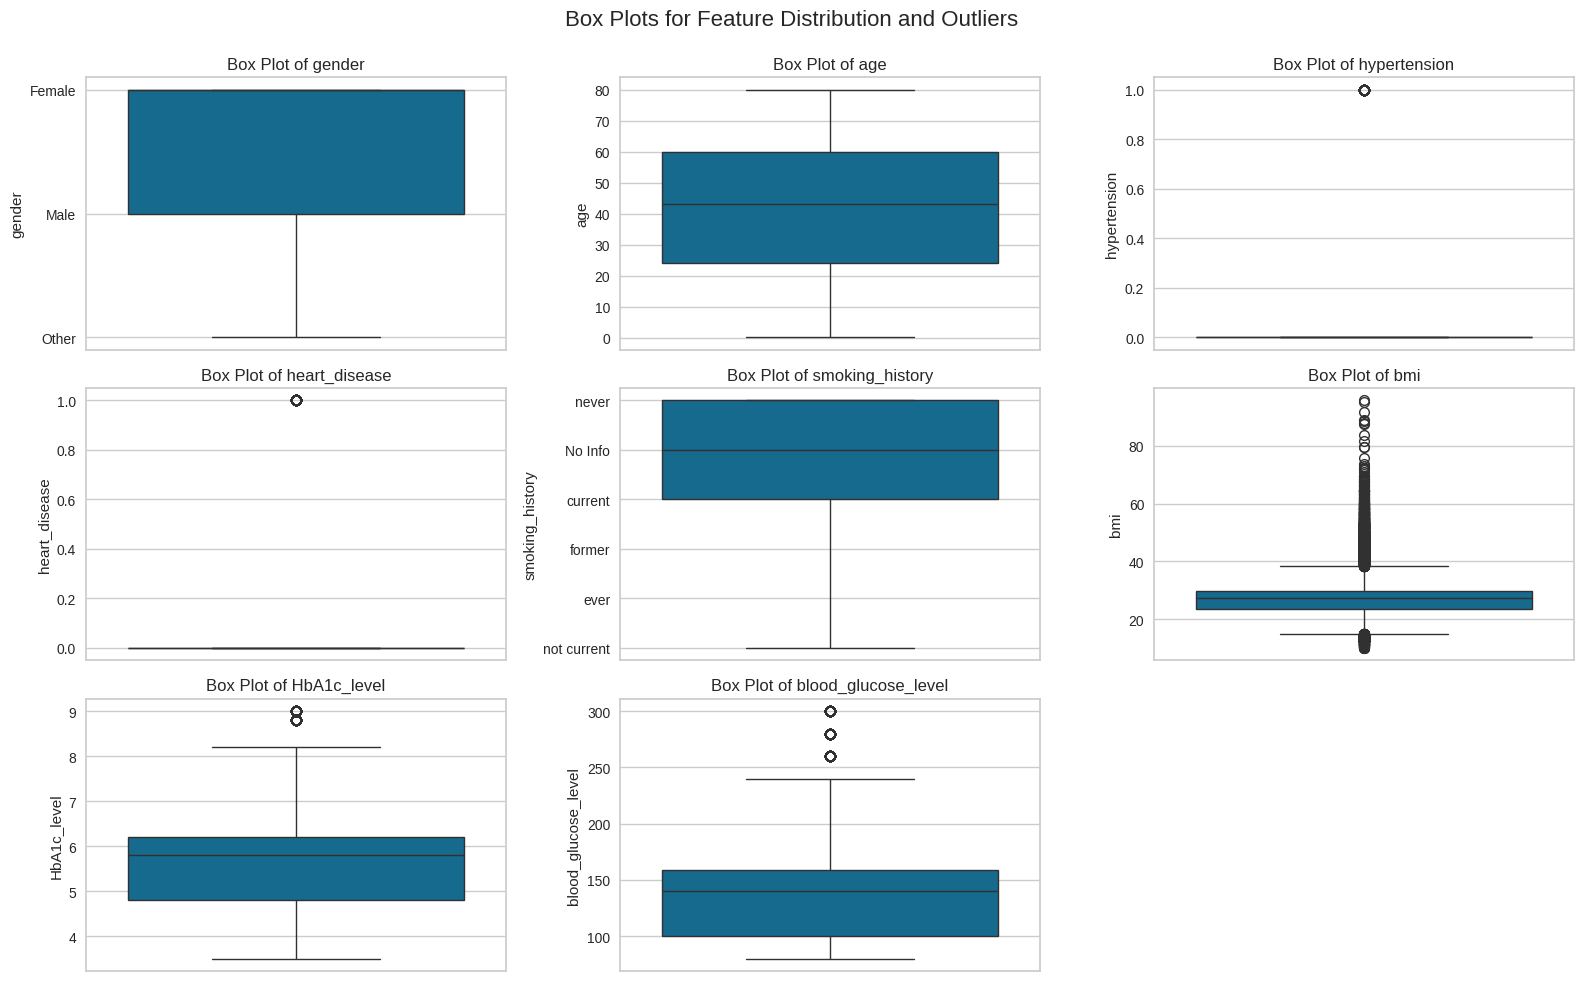

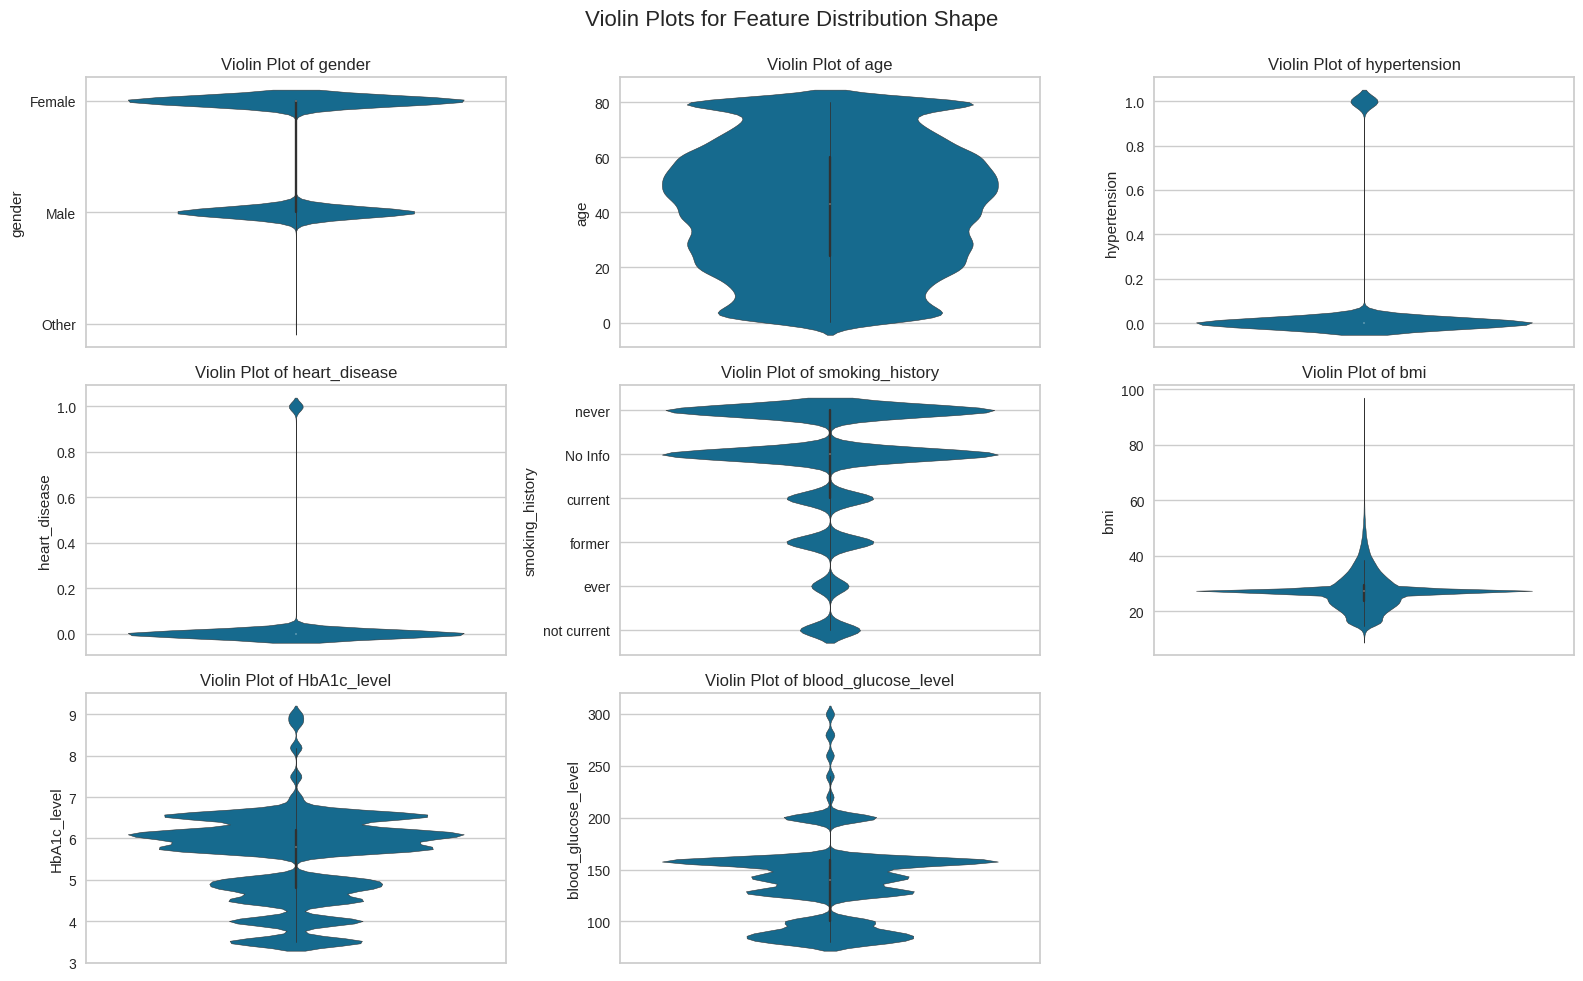

In [8]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Box Plots for Feature Distribution and Outliers', y=0.98, fontsize=16)
plt.show()

plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.violinplot(y=df[col])
    plt.title(f'Violin Plot of {col}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Violin Plots for Feature Distribution Shape', y=0.98, fontsize=16)
plt.show()

#### 3.2 Bivariate Analysis

Analyze relationships between features and the target variable to identify useful predictive patterns.

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


<ipython-input-9-51bebe6b899b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome_col, y=col, data=df, palette='viridis')
<ipython-input-9-51bebe6b899b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome_col, y=col, data=df, palette='viridis')
<ipython-input-9-51bebe6b899b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome_col, y=col, data=df, palette='viridis')
<ipython-input-9-51bebe6b899b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x`

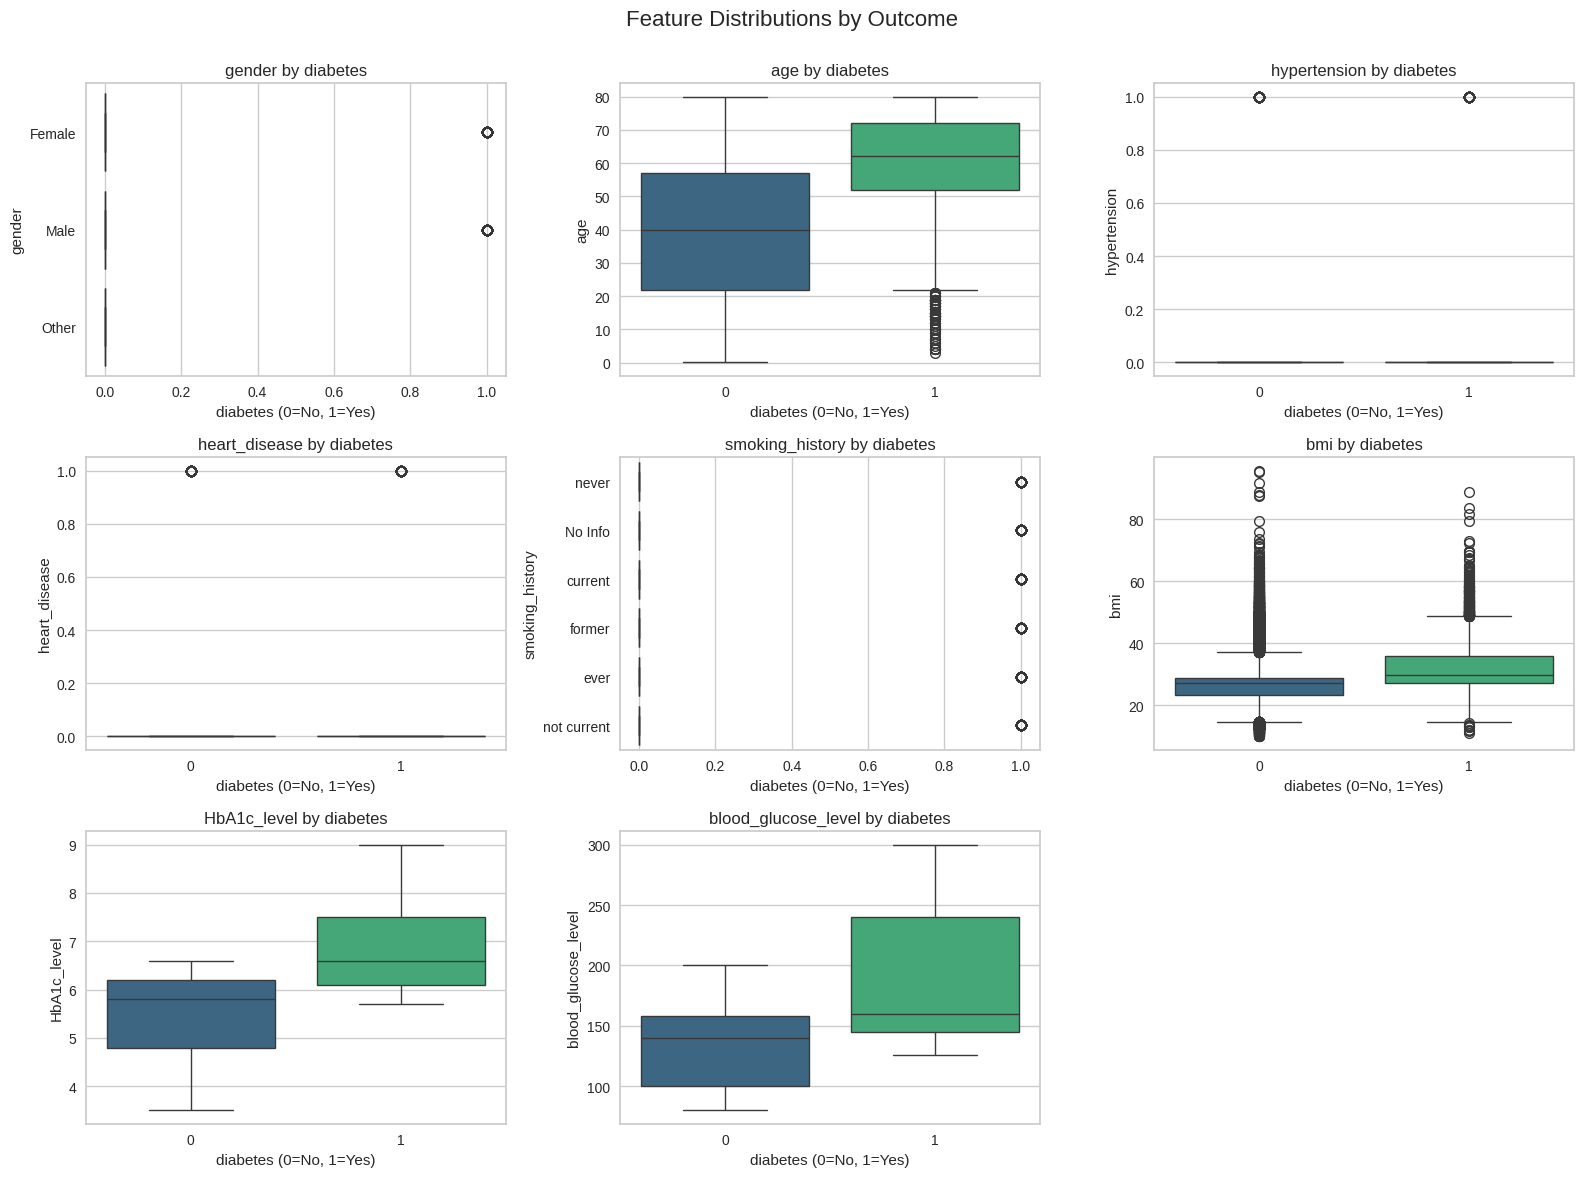

In [9]:
print("Columns:", df.columns.tolist())

outcome_col = df.columns[-1]
features    = [c for c in df.columns if c!=outcome_col]
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=outcome_col, y=col, data=df, palette='viridis')
    plt.title(f'{col} by {outcome_col}')
    plt.xlabel(f'{outcome_col} (0=No, 1=Yes)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions by Outcome', y=0.98, fontsize=16)
plt.show()

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


<ipython-input-10-44ff52d09ada>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=outcome_col, y=col, data=df, palette='viridis')
<ipython-input-10-44ff52d09ada>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=outcome_col, y=col, data=df, palette='viridis')
<ipython-input-10-44ff52d09ada>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=outcome_col, y=col, data=df, palette='viridis')
<ipython-input-10-44ff52d09ada>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. A

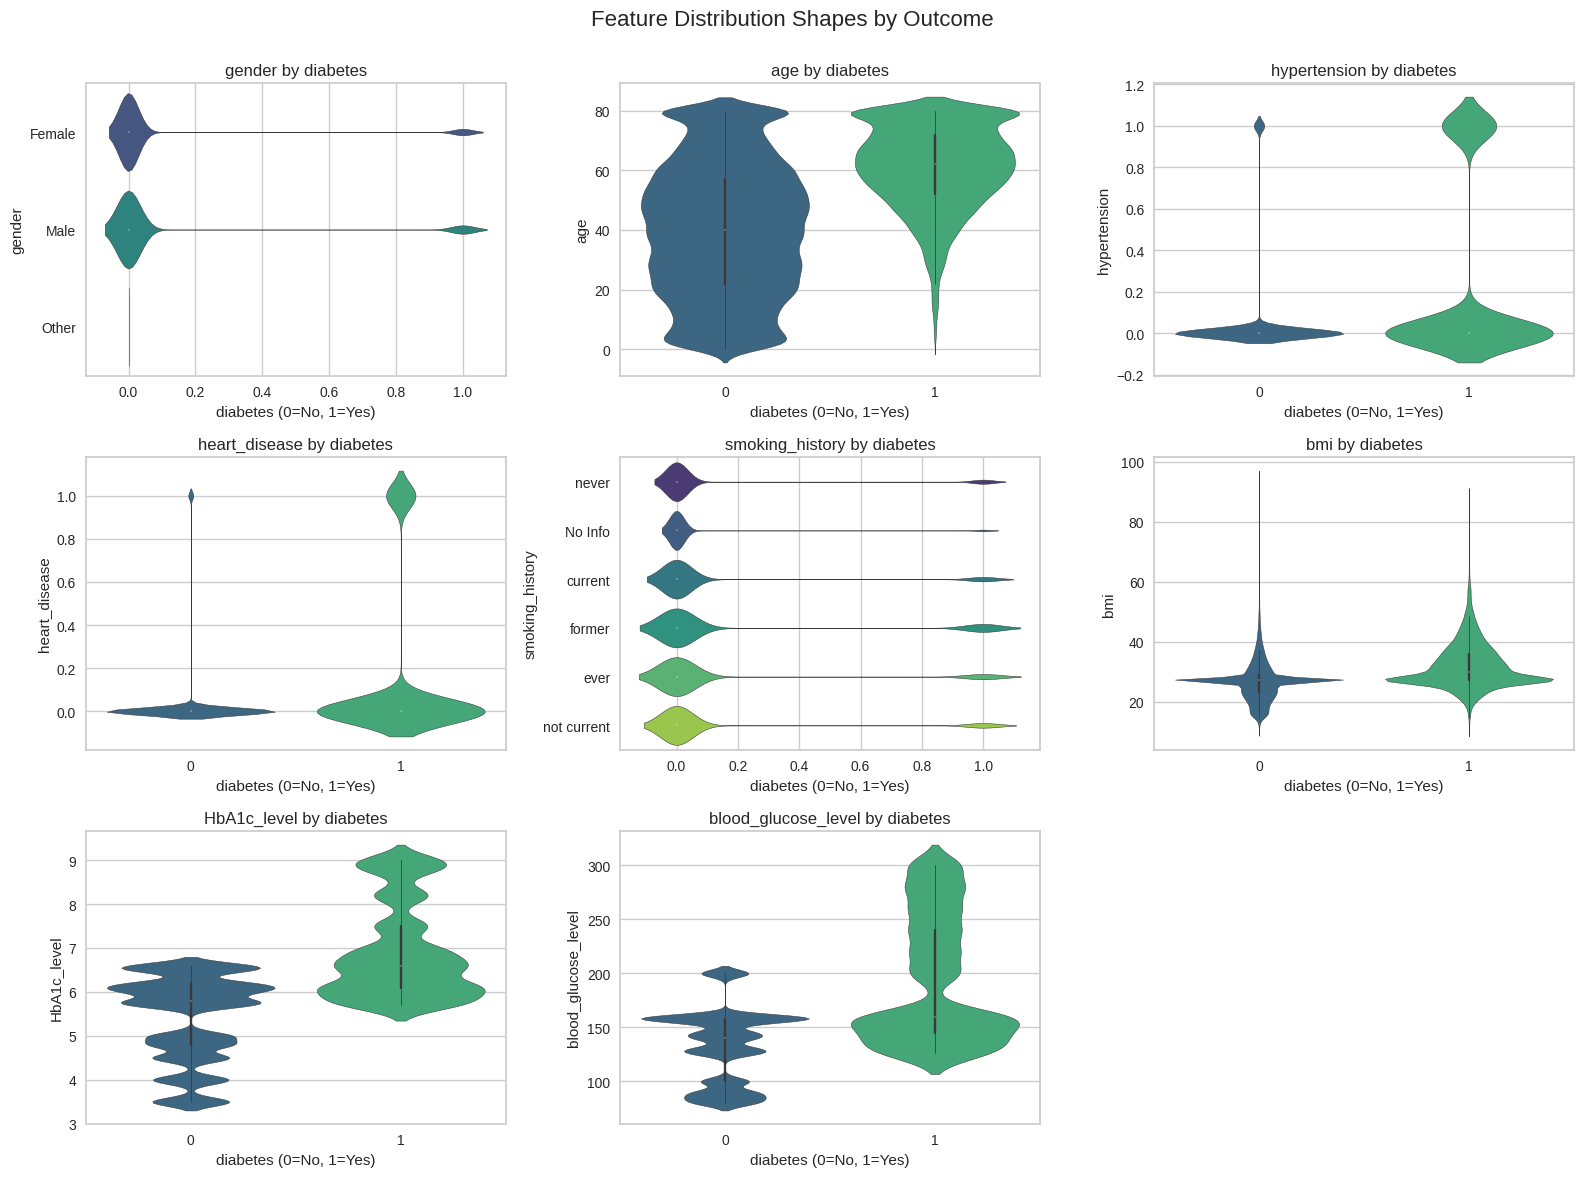

In [10]:
print("Columns:", df.columns.tolist())

outcome_col = df.columns[-1]
features    = [c for c in df.columns if c != outcome_col]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.violinplot(x=outcome_col, y=col, data=df, palette='viridis')
    plt.title(f'{col} by {outcome_col}')
    plt.xlabel(f'{outcome_col} (0=No, 1=Yes)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distribution Shapes by Outcome', y=0.98, fontsize=16)
plt.show()

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


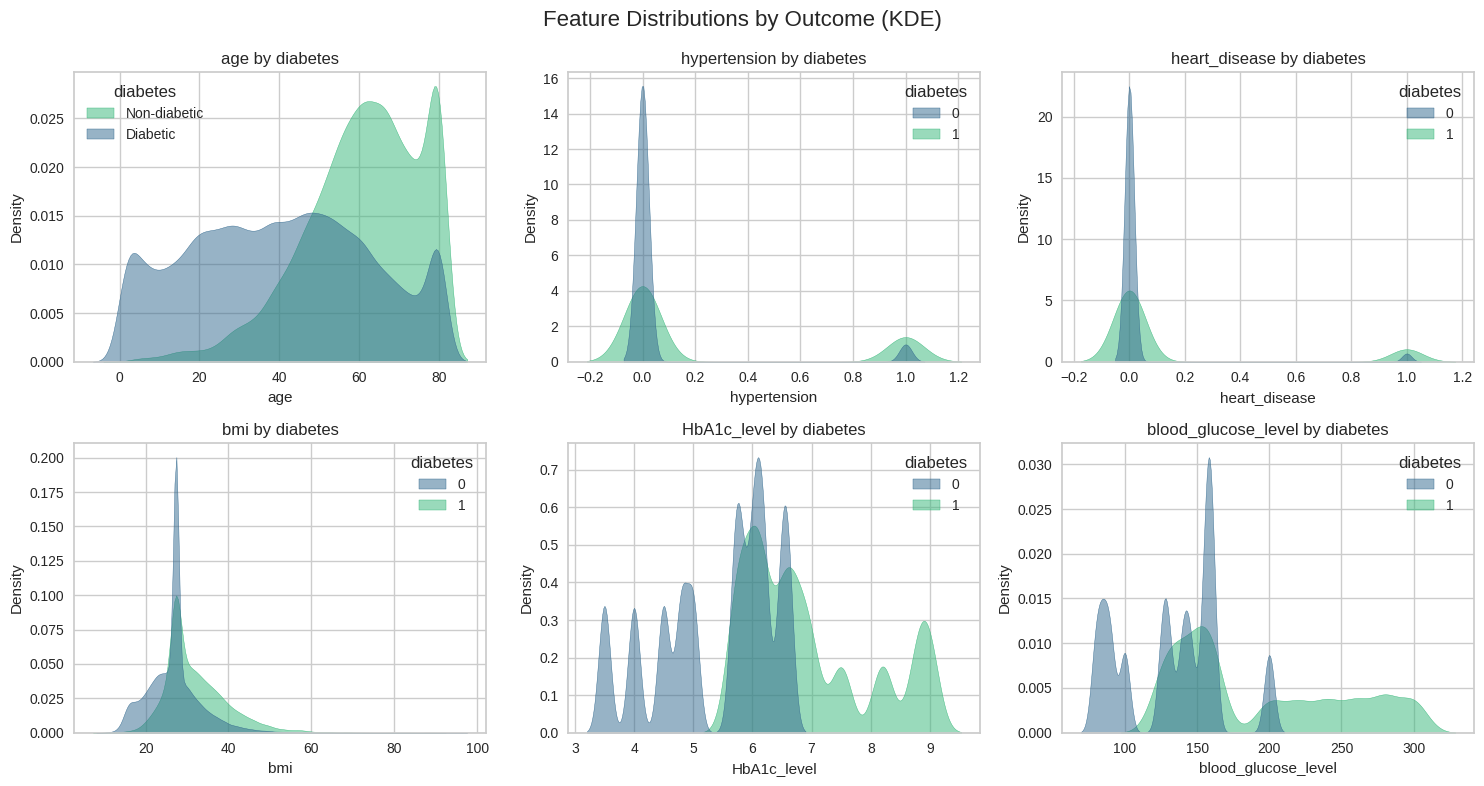

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

print("Columns:", df.columns.tolist())
outcome_col = 'diabetes'

numeric_features = df.select_dtypes(include='number').columns.tolist()
numeric_features.remove(outcome_col)

n = len(numeric_features)
n_cols = 3
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numeric_features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(
        data=df,
        x=col,
        hue=outcome_col,
        fill=True,
        palette='viridis',
        alpha=0.5,
        common_norm=False,
        ax=ax
    )
    ax.set_title(f'{col} by {outcome_col}')
    if i == 0:
        ax.legend(title=outcome_col, labels=['Non‑diabetic', 'Diabetic'])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions by Outcome (KDE)', y=0.98, fontsize=16)
plt.show()

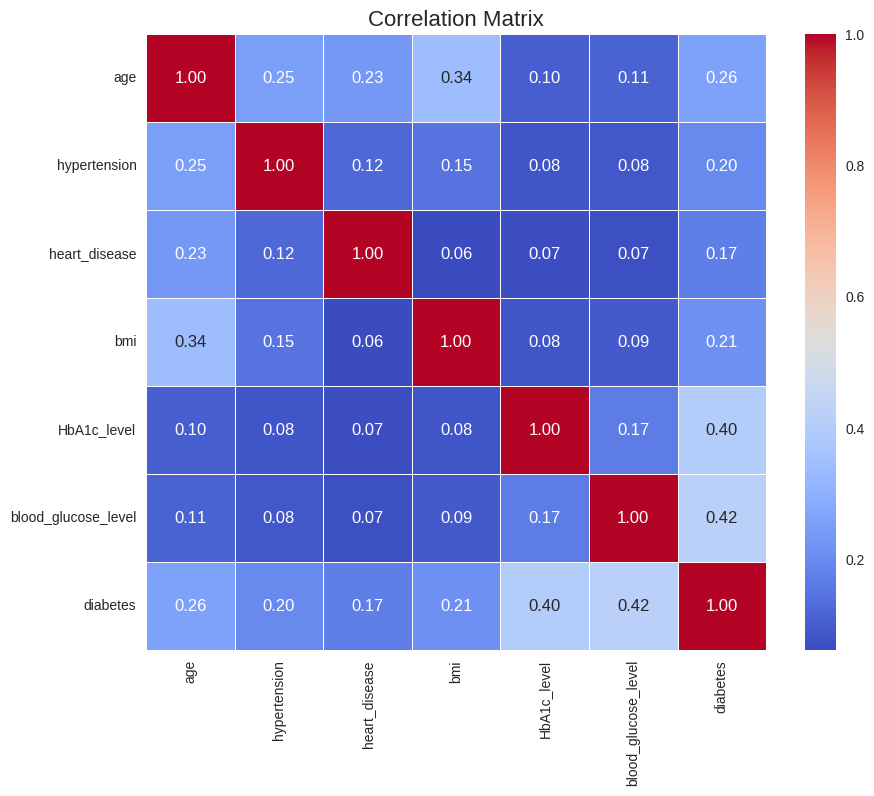

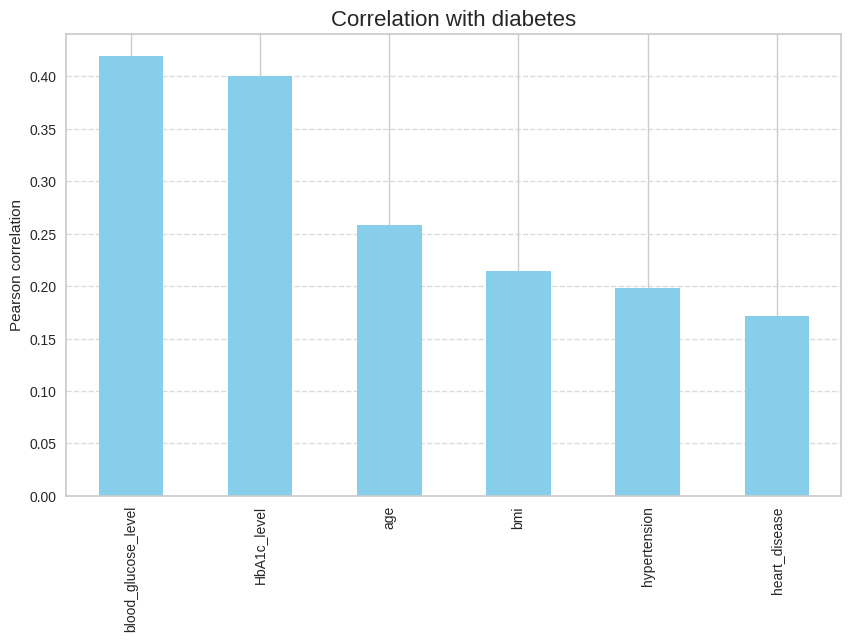

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
corr_mat = numeric_df.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

target_col = 'diabetes'
corr_target = corr_mat[target_col].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_target.drop(target_col).plot(kind='bar', color='skyblue')
plt.title(f'Correlation with {target_col}', fontsize=16)
plt.ylabel('Pearson correlation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 3.3 Multivariate Analysis

Explore how multiple variables interact with each other and the target outcome.

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
Pairplot features: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


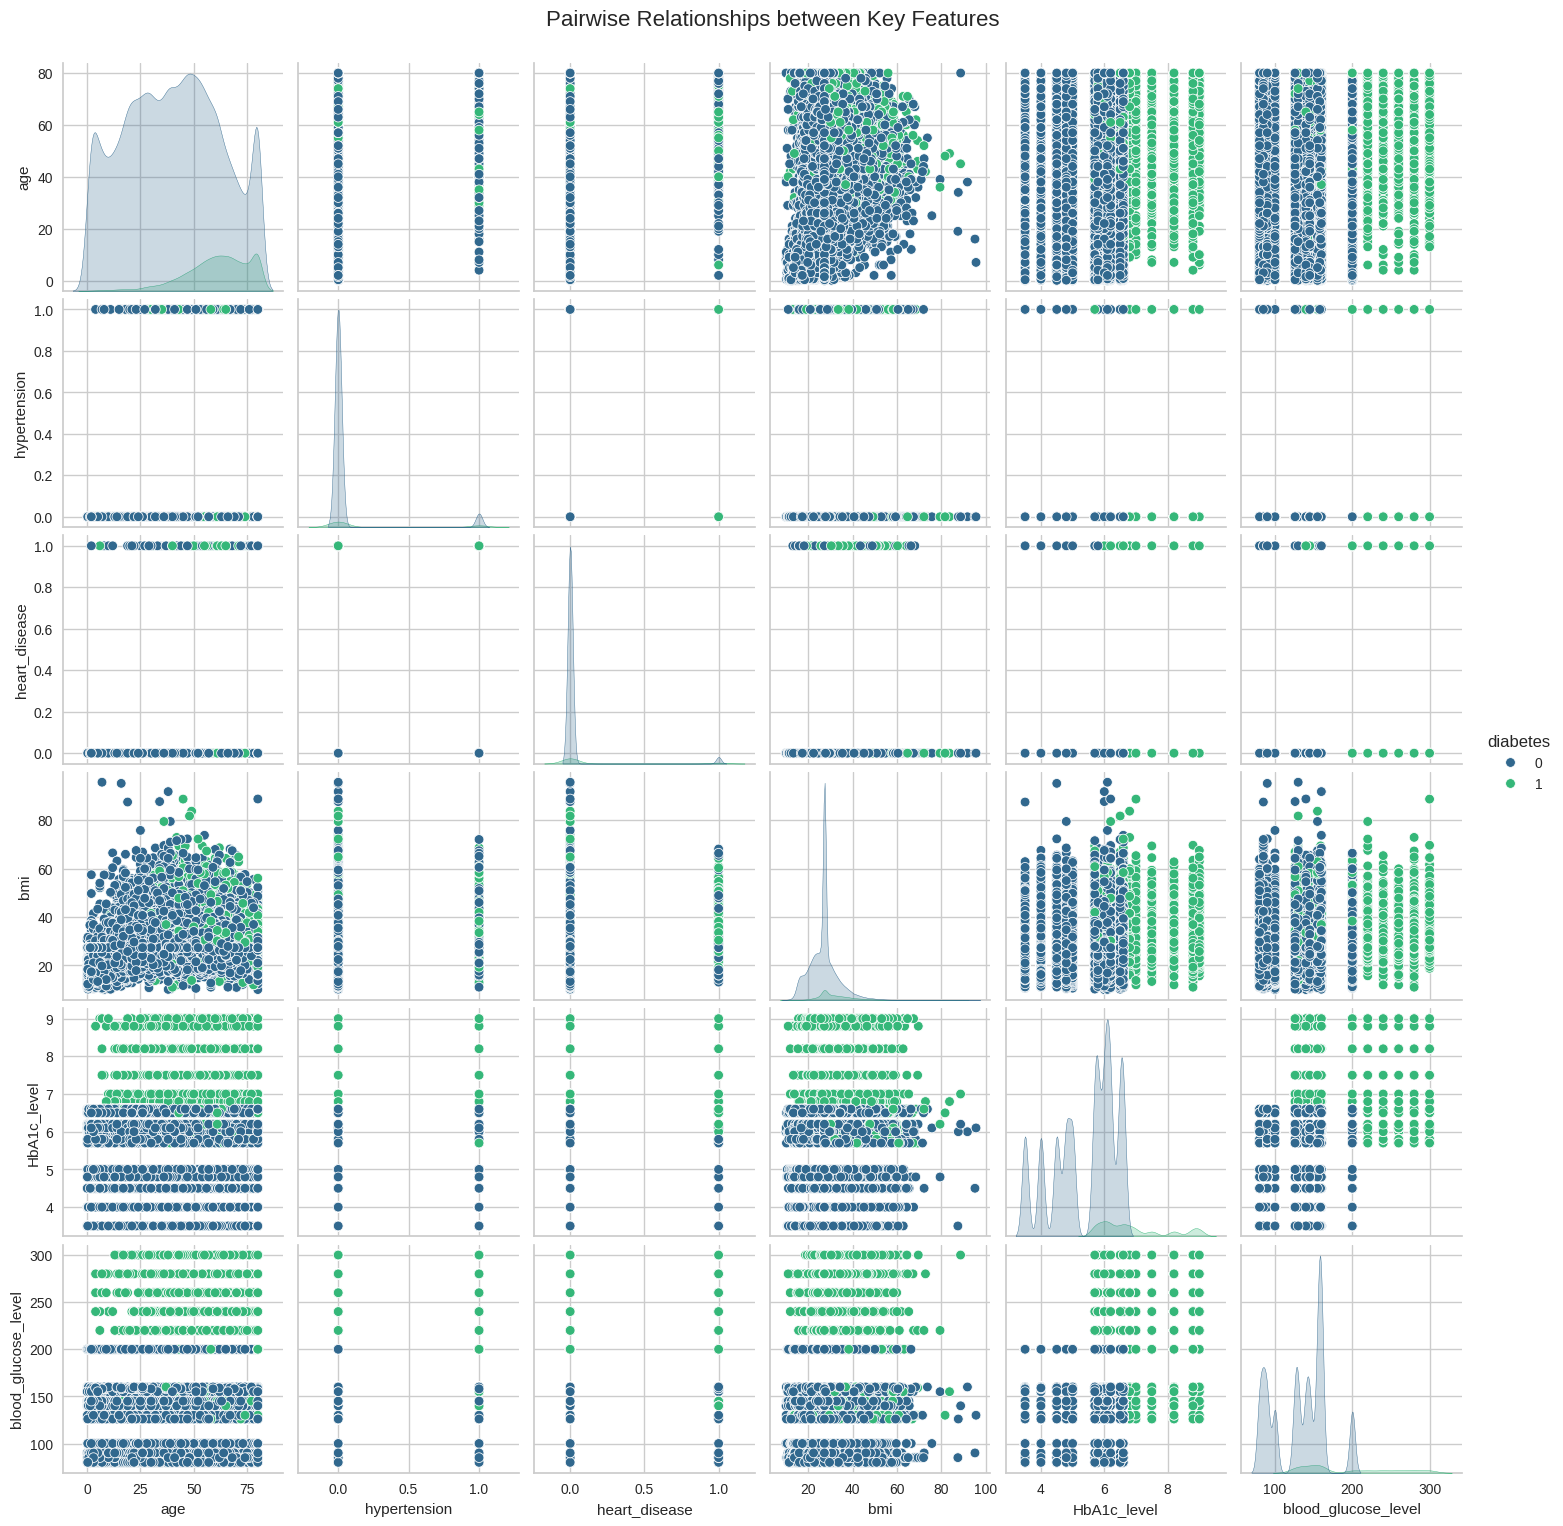

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Columns:", df.columns.tolist())

target_col    = 'diabetes'
numeric_feats = df.select_dtypes(include='number').columns.tolist()
numeric_feats.remove(target_col)

key_features = numeric_feats + [target_col]
print("Pairplot features:", key_features)

sns.pairplot(
    df[key_features],
    hue=target_col,
    palette='viridis',
    diag_kind='kde'
)
plt.suptitle('Pairwise Relationships between Key Features', y=1.02, fontsize=16)
plt.show()

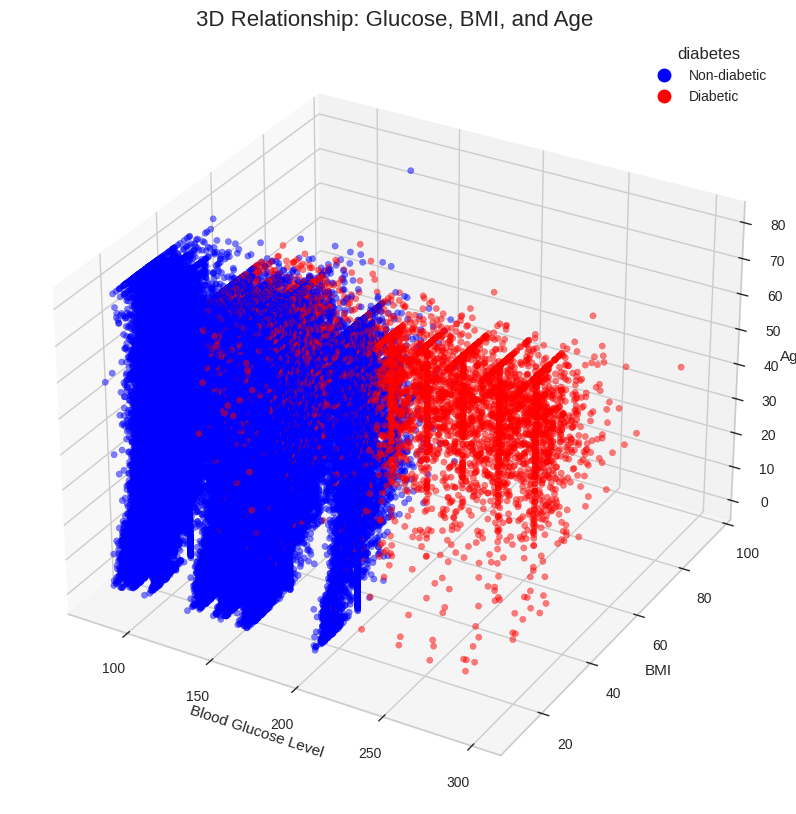

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

x_col = 'blood_glucose_level'
y_col = 'bmi'
z_col = 'age'
target = 'diabetes'

fig = plt.figure(figsize=(12, 10))
ax  = fig.add_subplot(111, projection='3d')

xs     = df[x_col]
ys     = df[y_col]
zs     = df[z_col]
colors = ['blue' if o==0 else 'red' for o in df[target]]

ax.scatter(xs, ys, zs, c=colors, alpha=0.5)
ax.set_xlabel('Blood Glucose Level')
ax.set_ylabel('BMI')
ax.set_zlabel('Age')
ax.set_title('3D Relationship: Glucose, BMI, and Age', fontsize=16)

legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='Non‑diabetic',
           markerfacecolor='blue', markersize=10),
    Line2D([0],[0], marker='o', color='w', label='Diabetic',
           markerfacecolor='red', markersize=10)
]
ax.legend(handles=legend_elements, title=target)

plt.show()

#### 3.4 Statistical Testing

Perform statistical tests to validate observed differences between diabetic and non-diabetic groups.

In [15]:
import numpy as np
import scipy.stats as stats

target       = 'diabetes'
numeric_cols = df.select_dtypes(include='number').columns.tolist()
features     = [c for c in numeric_cols if c != target]

print("T‑tests comparing diabetic vs. non‑diabetic groups:\n")
for col in features:
    grp1 = df.loc[df[target] == 1, col]
    grp0 = df.loc[df[target] == 0, col]
    t_stat, p_val = stats.ttest_ind(grp1, grp0, equal_var=False, nan_policy='omit')

    print(f"{col}:")
    print(f"  Mean (Diabetic):     {grp1.mean():.2f}")
    print(f"  Mean (Non‑diabetic): {grp0.mean():.2f}")
    print(f"  T‑statistic:         {t_stat:.4f}")
    print(f"  P‑value:             {p_val:.4f}")
    print(f"  Significant (α=0.05): {'Yes' if p_val < 0.05 else 'No'}\n")

T‑tests comparing diabetic vs. non‑diabetic groups:

age:
  Mean (Diabetic):     60.95
  Mean (Non‑diabetic): 40.12
  T‑statistic:         119.5874
  P‑value:             0.0000
  Significant (α=0.05): Yes

hypertension:
  Mean (Diabetic):     0.25
  Mean (Non‑diabetic): 0.06
  T‑statistic:         39.4313
  P‑value:             0.0000
  Significant (α=0.05): Yes

heart_disease:
  Mean (Diabetic):     0.15
  Mean (Non‑diabetic): 0.03
  T‑statistic:         30.6995
  P‑value:             0.0000
  Significant (α=0.05): Yes

bmi:
  Mean (Diabetic):     31.99
  Mean (Non‑diabetic): 26.89
  T‑statistic:         60.2651
  P‑value:             0.0000
  Significant (α=0.05): Yes

HbA1c_level:
  Mean (Diabetic):     6.93
  Mean (Non‑diabetic): 5.40
  T‑statistic:         127.0111
  P‑value:             0.0000
  Significant (α=0.05): Yes

blood_glucose_level:
  Mean (Diabetic):     194.09
  Mean (Non‑diabetic): 132.85
  T‑statistic:         94.7949
  P‑value:             0.0000
  Significant (α=

ANOVA F-values and p-values for each feature:


Feature       F-value  P-value
5  blood_glucose_level  21363.054361      0.0
4          HbA1c_level  19122.211184      0.0
0                  age   7131.405852      0.0
3                  bmi   4816.113932      0.0
1         hypertension   4072.706875      0.0
2        heart_disease   3038.559564      0.0

<ipython-input-16-788dcf8f300d>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


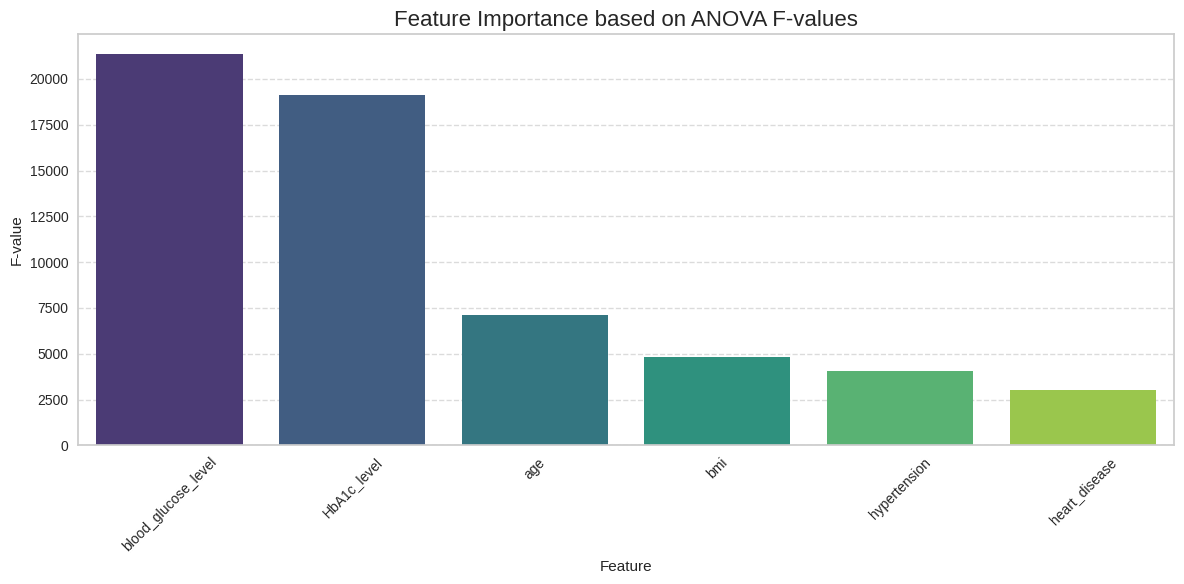

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

target_col = 'diabetes'

X = df.select_dtypes(include='number').drop(columns=[target_col])
y = df[target_col]

f_values, p_values = f_classif(X, y)

feature_scores = (
    pd.DataFrame({
        'Feature': X.columns,
        'F-value': f_values,
        'P-value': p_values
    })
    .sort_values('F-value', ascending=False)
)
print("ANOVA F-values and p-values for each feature:")
display(feature_scores)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Feature',
    y='F-value',
    data=feature_scores,
    palette='viridis'
)
plt.xticks(rotation=45)
plt.title('Feature Importance based on ANOVA F-values', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Part 2: Data Preprocessing & Feature Engineering


### Data Preprocessing & Feature Engineering

This section covers data cleaning, feature engineering, and preparation for modeling.

In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

np.random.seed(42)

df = pd.read_csv('/content/diabetes.csv')
df.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

#### 4. Data Preprocessing

Handle missing values, outliers, and perform feature transformations to improve model performance.

##### 4.1 Missing Value Treatment

Medical variables with zero values likely represent missing data. Replace zeros with NaN and impute appropriately.

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
Missing values after zero replacement:


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

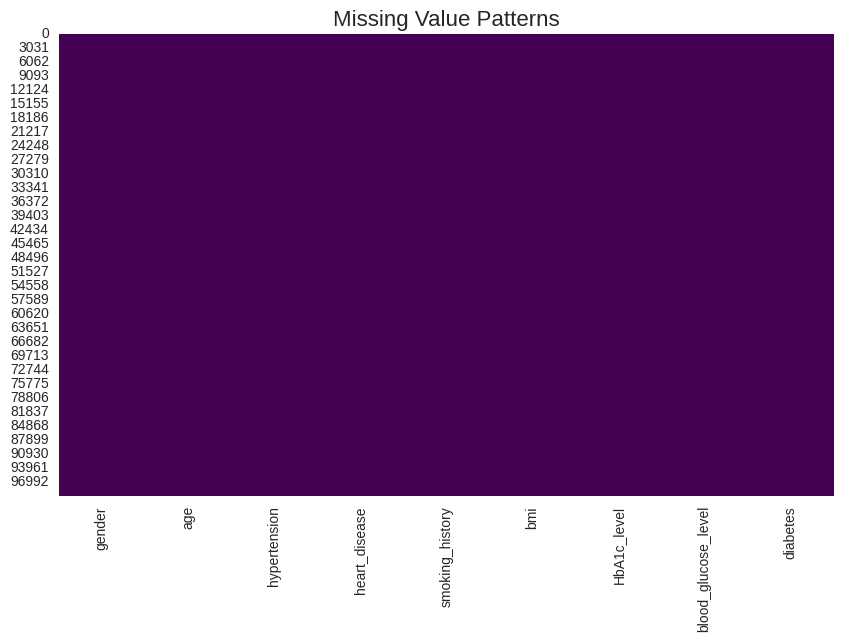

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Columns:", df.columns.tolist())

df_clean = df.copy()

zero_cols = ['bmi', 'HbA1c_level', 'blood_glucose_level']
for col in zero_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(0, np.nan)

print("Missing values after zero replacement:")
display(df_clean.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Patterns', fontsize=16)
plt.show()

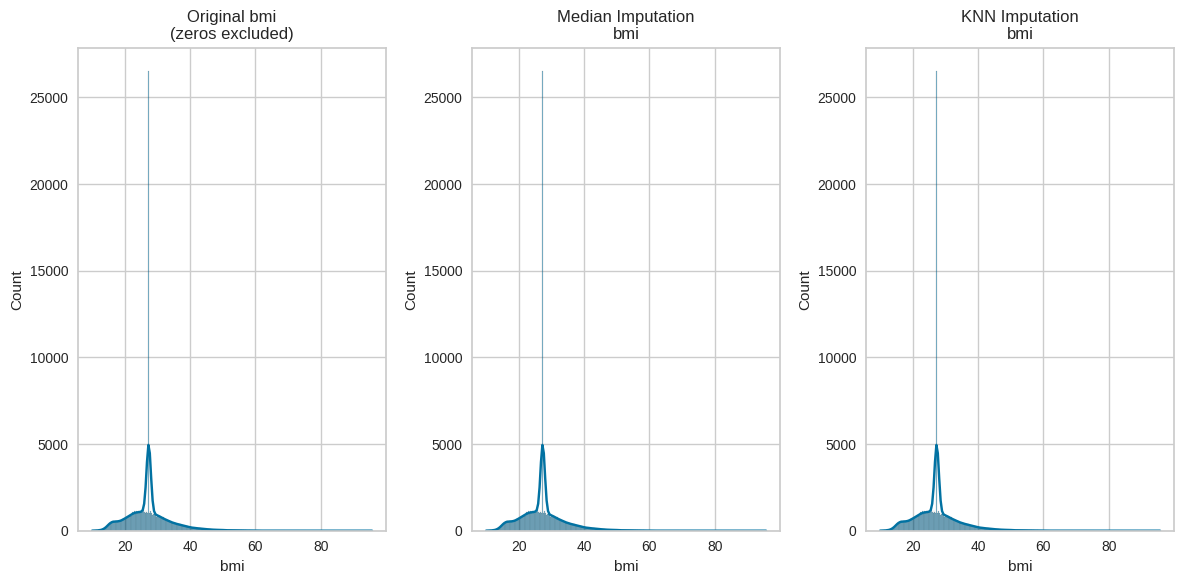

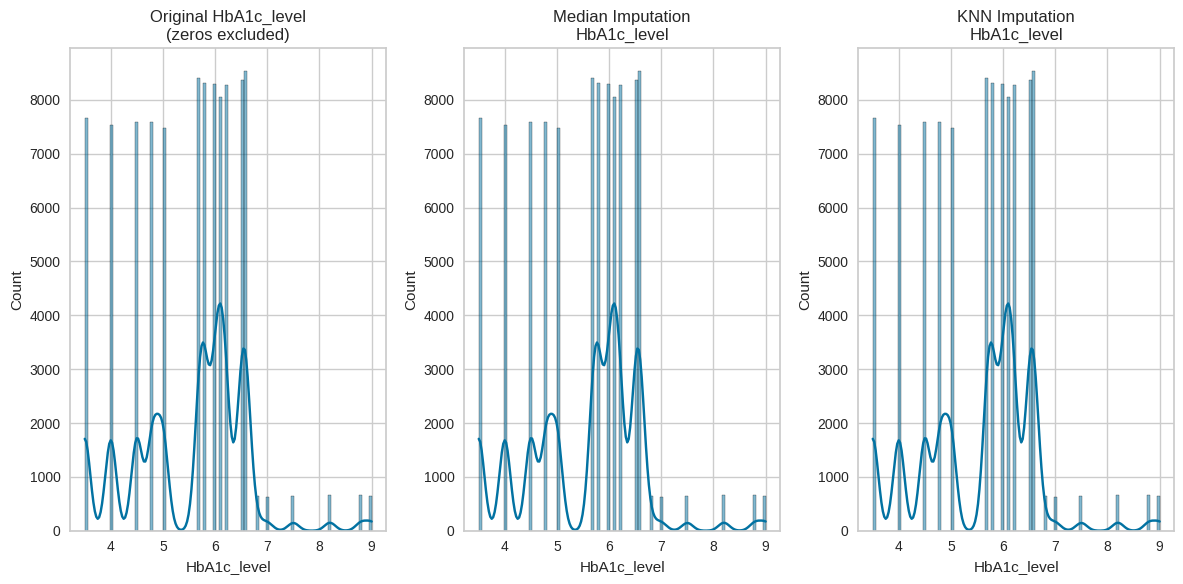

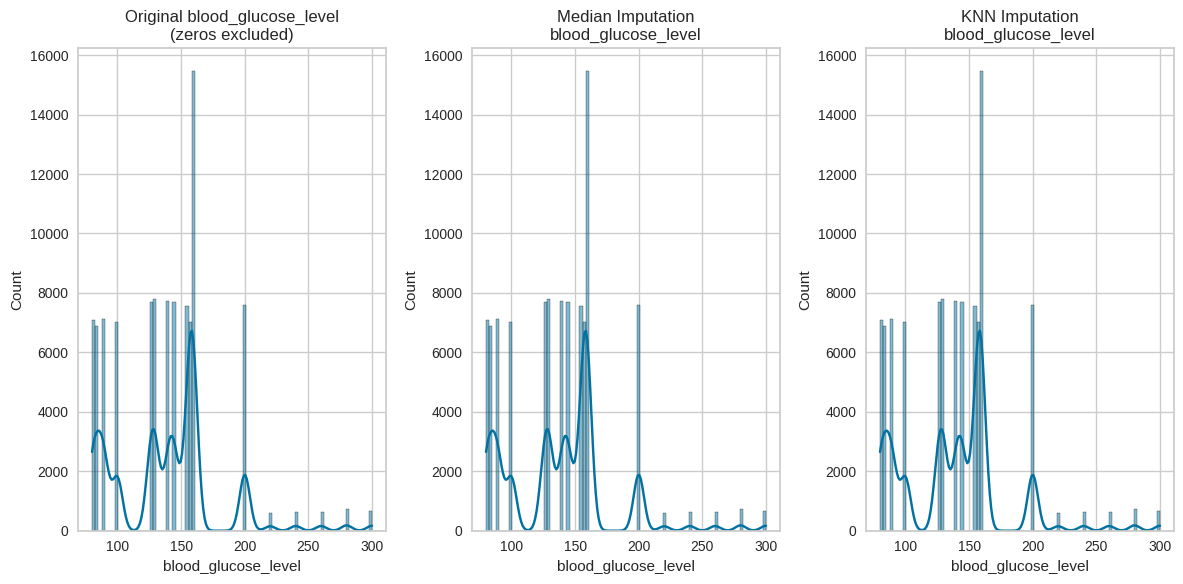

In [19]:
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

df_median = df_clean.copy()
df_knn    = df_clean.copy()

median_imputer = SimpleImputer(strategy='median')
df_median[zero_cols] = median_imputer.fit_transform(df_median[zero_cols])

knn_imputer = KNNImputer(n_neighbors=5)
df_knn[zero_cols] = knn_imputer.fit_transform(df_knn[zero_cols])

for col in zero_cols:
    plt.figure(figsize=(12, 6))

    # original (zeros excluded)
    plt.subplot(1, 3, 1)
    sns.histplot(df[df[col] > 0][col], kde=True)
    plt.title(f'Original {col}\n(zeros excluded)')

    # median
    plt.subplot(1, 3, 2)
    sns.histplot(df_median[col], kde=True)
    plt.title(f'Median Imputation\n{col}')

    # knn
    plt.subplot(1, 3, 3)
    sns.histplot(df_knn[col], kde=True)
    plt.title(f'KNN Imputation\n{col}')

    plt.tight_layout()
    plt.show()

# 5. Choose median-imputed data for downstream
df_processed = df_median.copy()

##### 4.2 Outlier Detection & Handling

Identify and treat outliers using the IQR method to reduce their impact on model training.

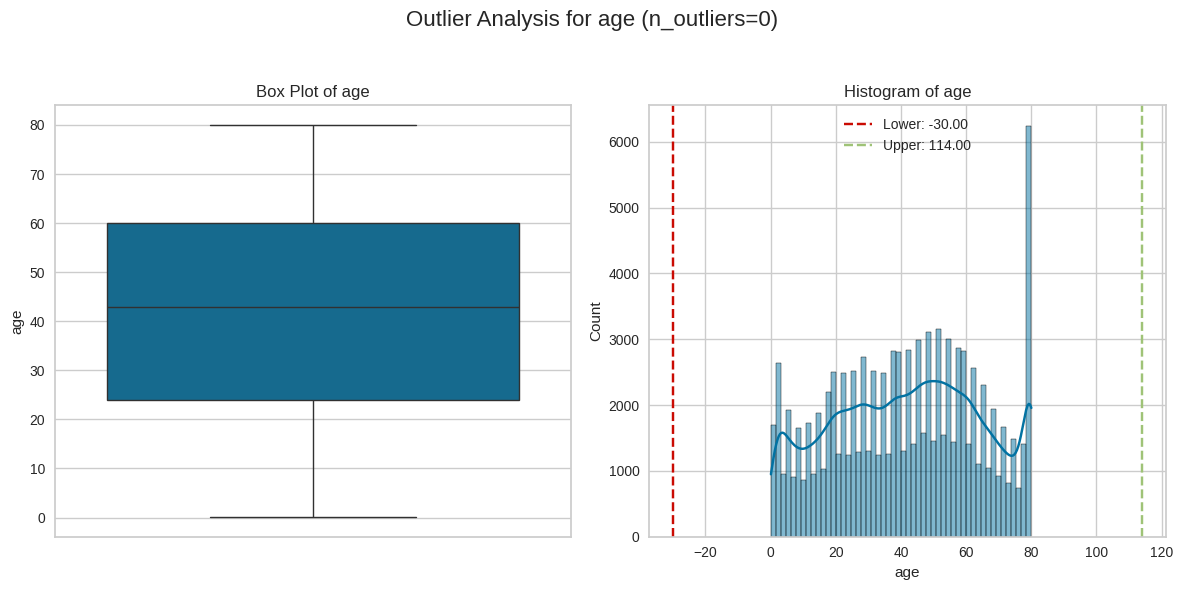

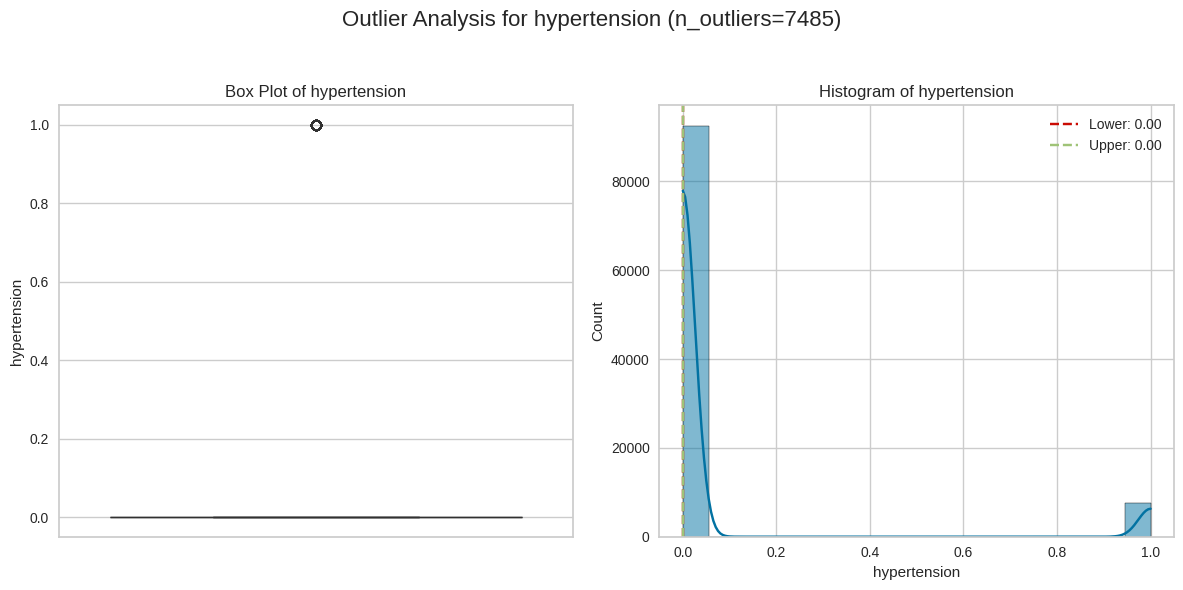

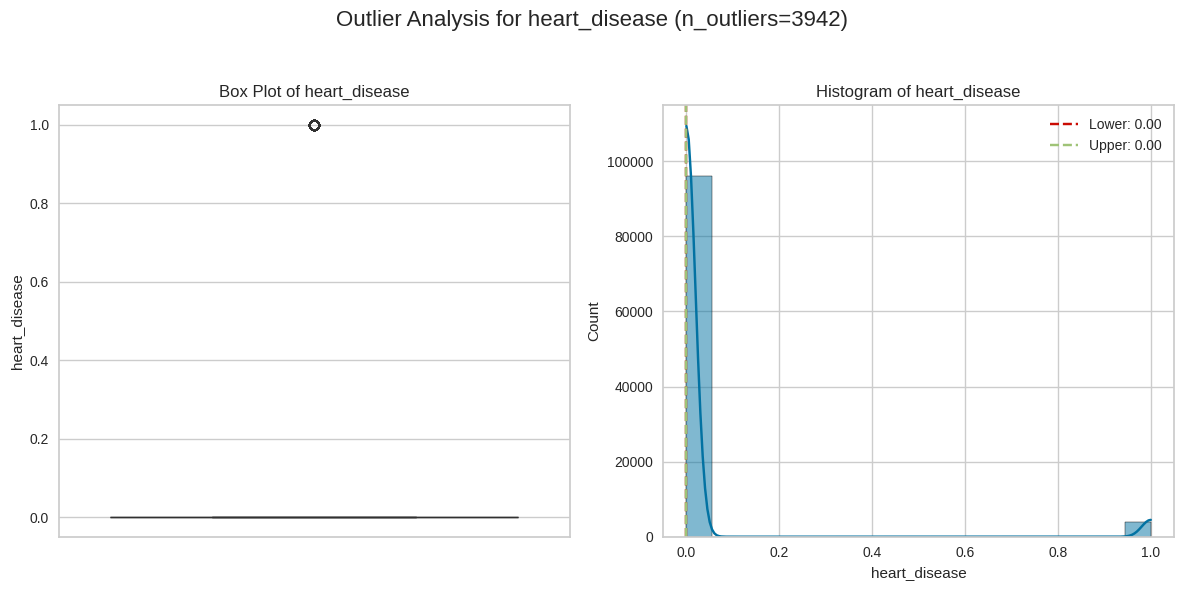

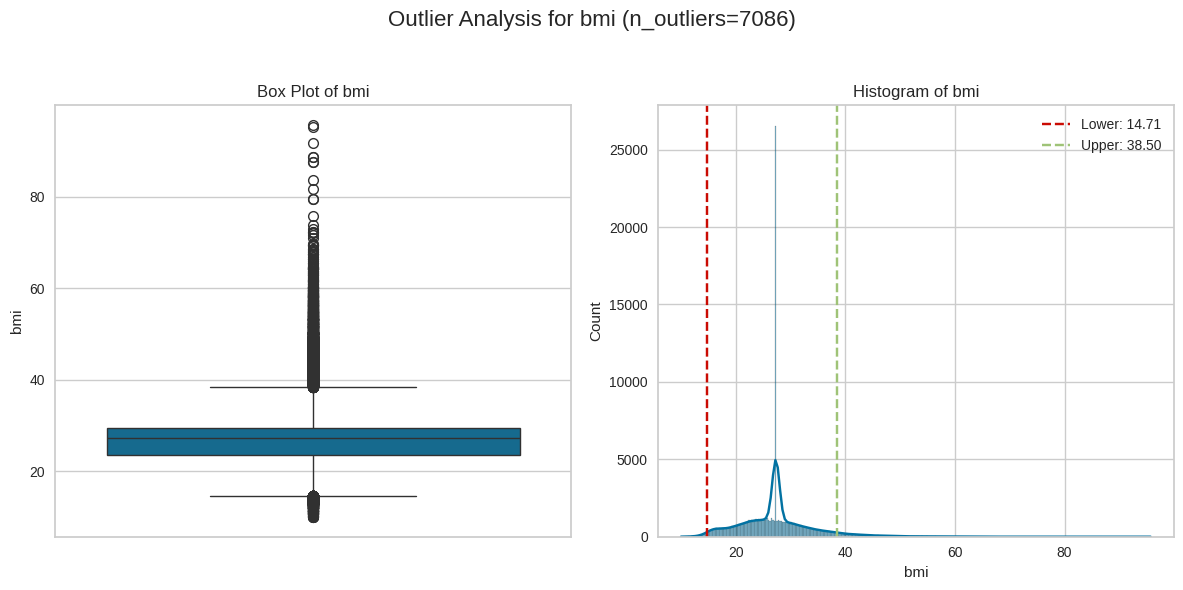

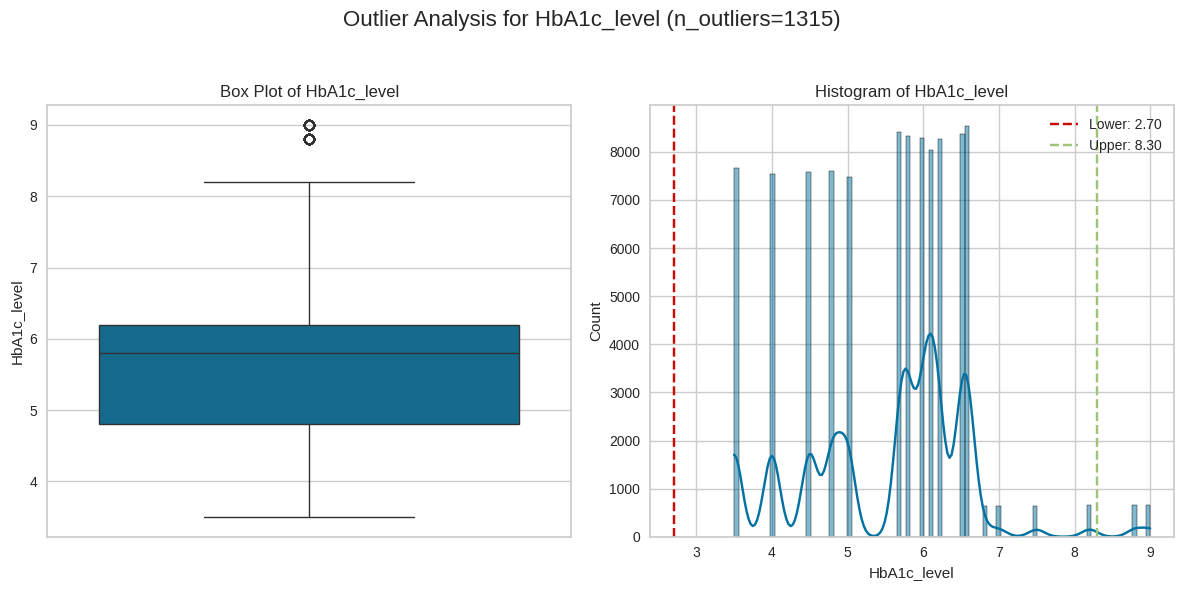

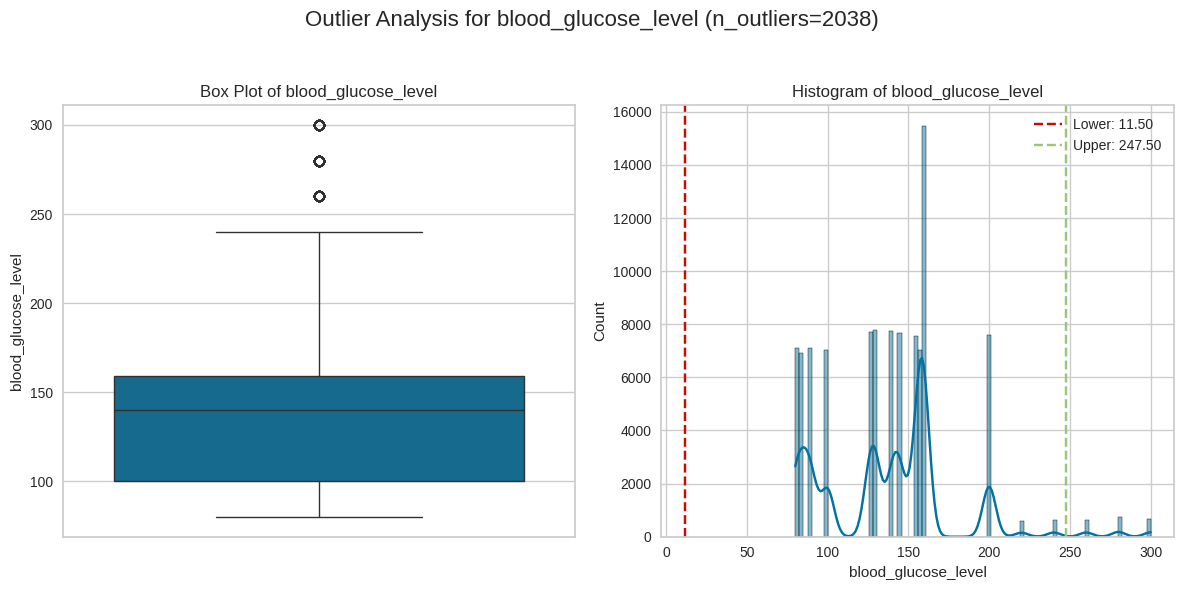

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def identify_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    return outliers, lower, upper

target       = 'diabetes'
numeric_cols = (
    df_processed
      .select_dtypes(include='number')
      .columns
      .tolist()
)
numeric_cols.remove(target)

for col in numeric_cols:
    outliers, lower, upper = identify_outliers(df_processed, col)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.boxplot(y=df_processed[col], ax=axes[0])
    axes[0].set_title(f'Box Plot of {col}')

    sns.histplot(df_processed[col], kde=True, ax=axes[1])
    axes[1].axvline(lower, color='r', linestyle='--',
                    label=f'Lower: {lower:.2f}')
    axes[1].axvline(upper, color='g', linestyle='--',
                    label=f'Upper: {upper:.2f}')
    axes[1].set_title(f'Histogram of {col}')
    axes[1].legend()

    plt.suptitle(f'Outlier Analysis for {col} (n_outliers={len(outliers)})',
                 fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

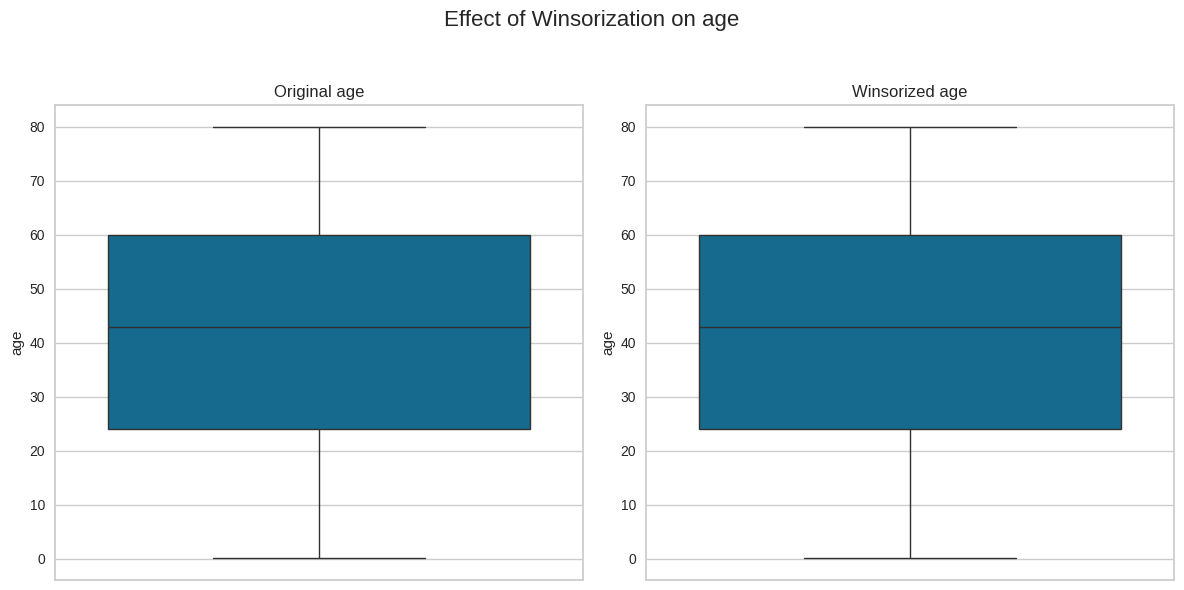

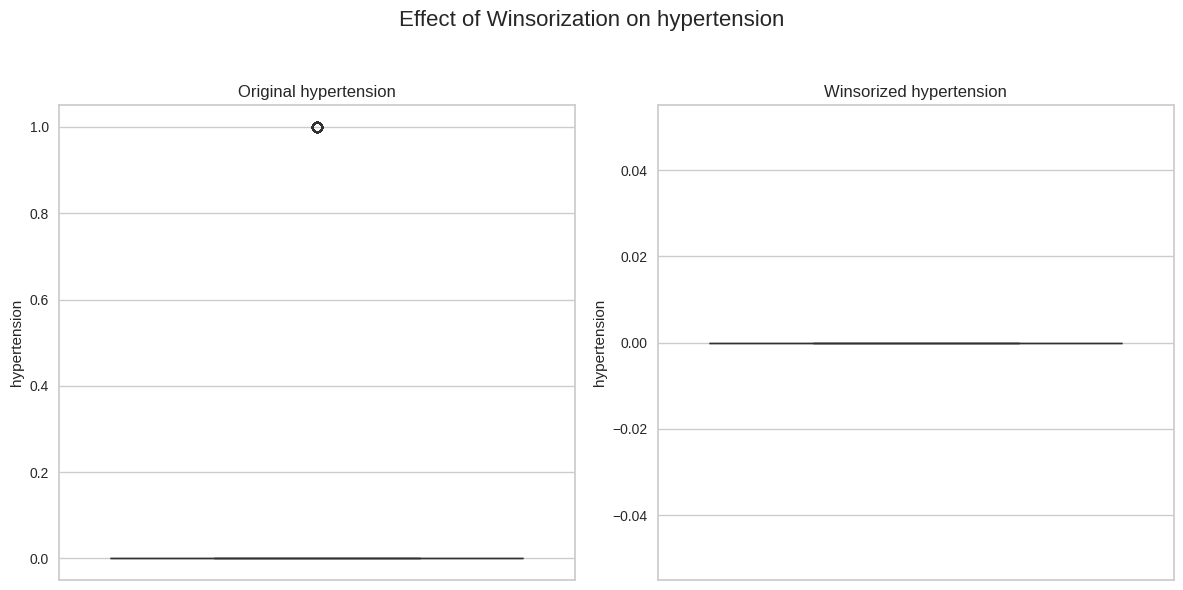

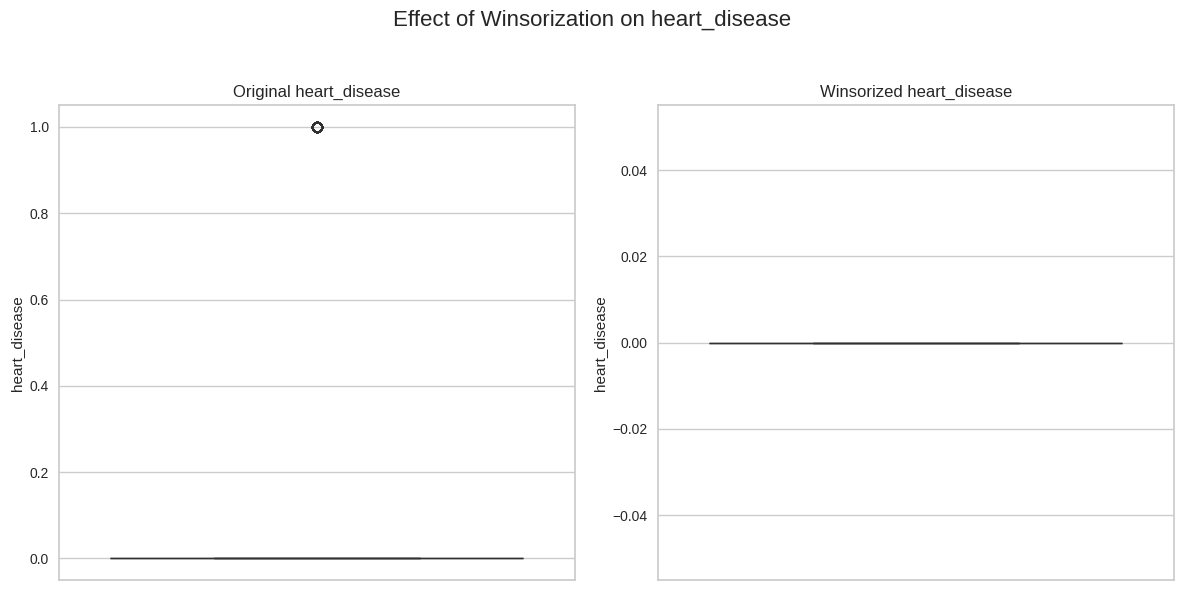

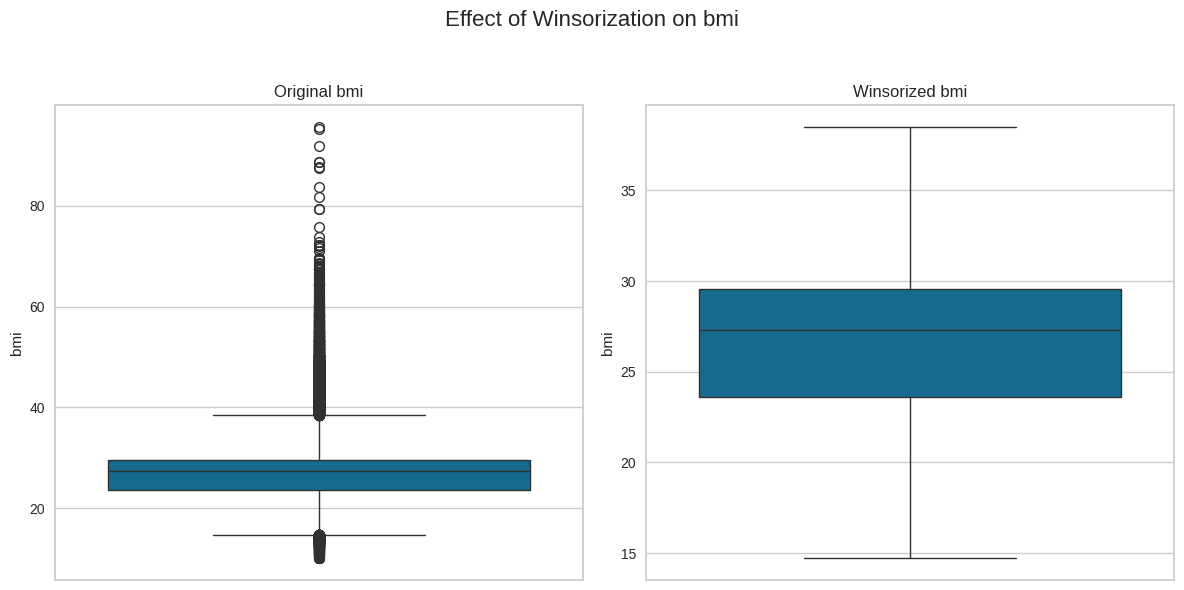

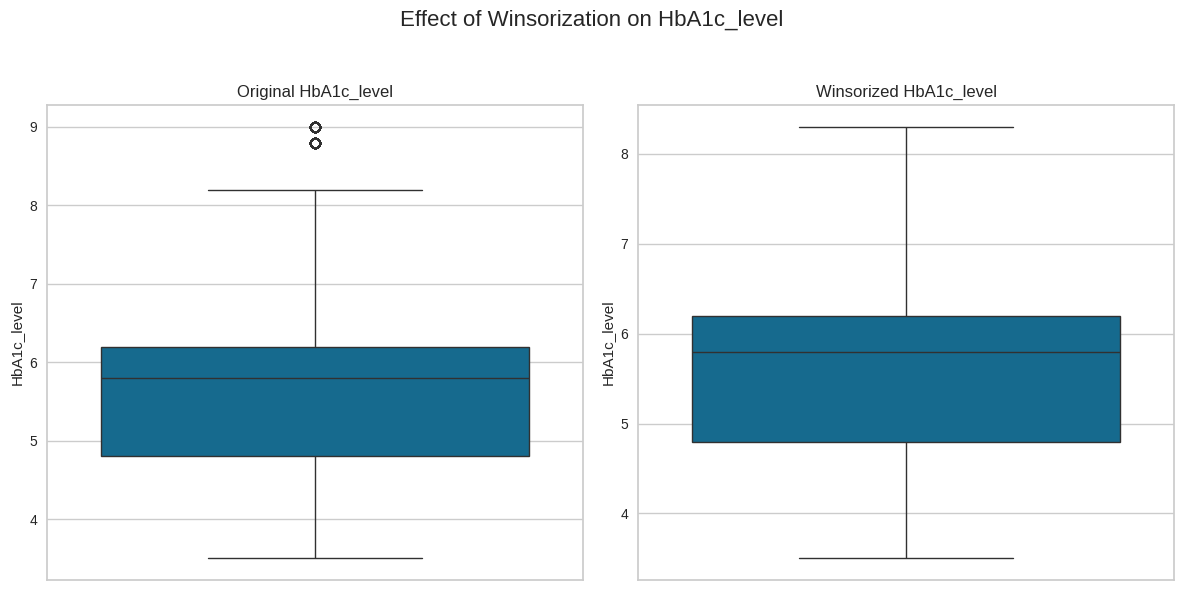

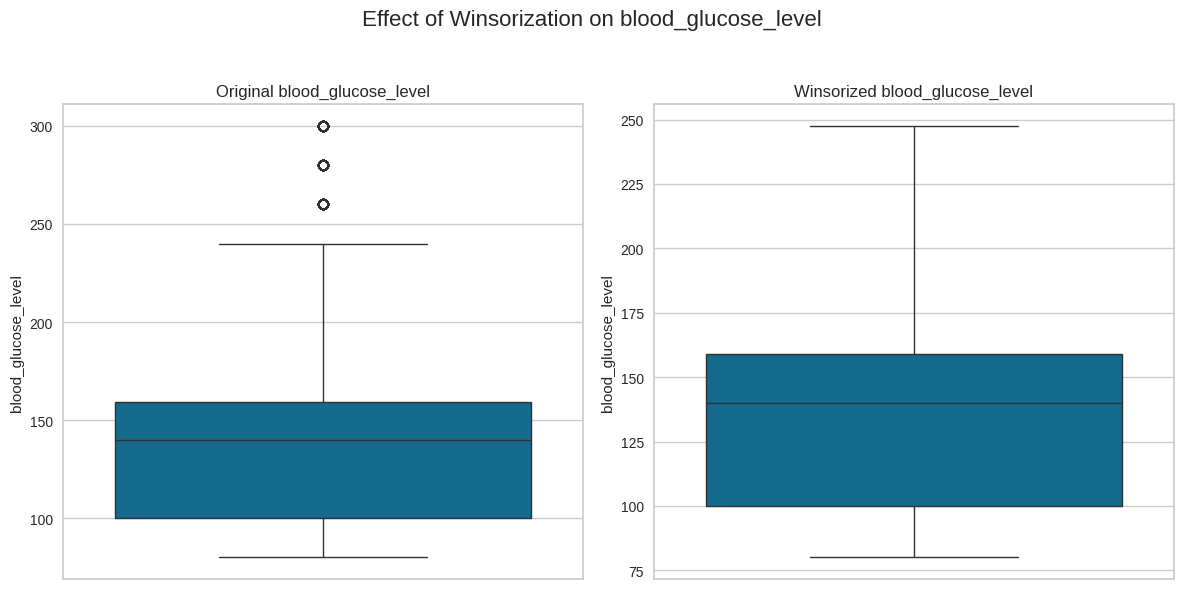

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

target = 'diabetes'
numeric_feats = [
    c for c in df_processed.select_dtypes(include='number').columns
    if c != target
]

df_winsor = df_processed.copy()
for col in numeric_feats:
    df_winsor[col] = cap_outliers(df_winsor[col])

for col in numeric_feats:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    sns.boxplot(y=df_processed[col], ax=ax1)
    ax1.set_title(f'Original {col}')

    sns.boxplot(y=df_winsor[col], ax=ax2)
    ax2.set_title(f'Winsorized {col}')

    fig.suptitle(f'Effect of Winsorization on {col}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

##### 4.3 Feature Transformation

Apply scaling and normalization to features as needed for model compatibility.

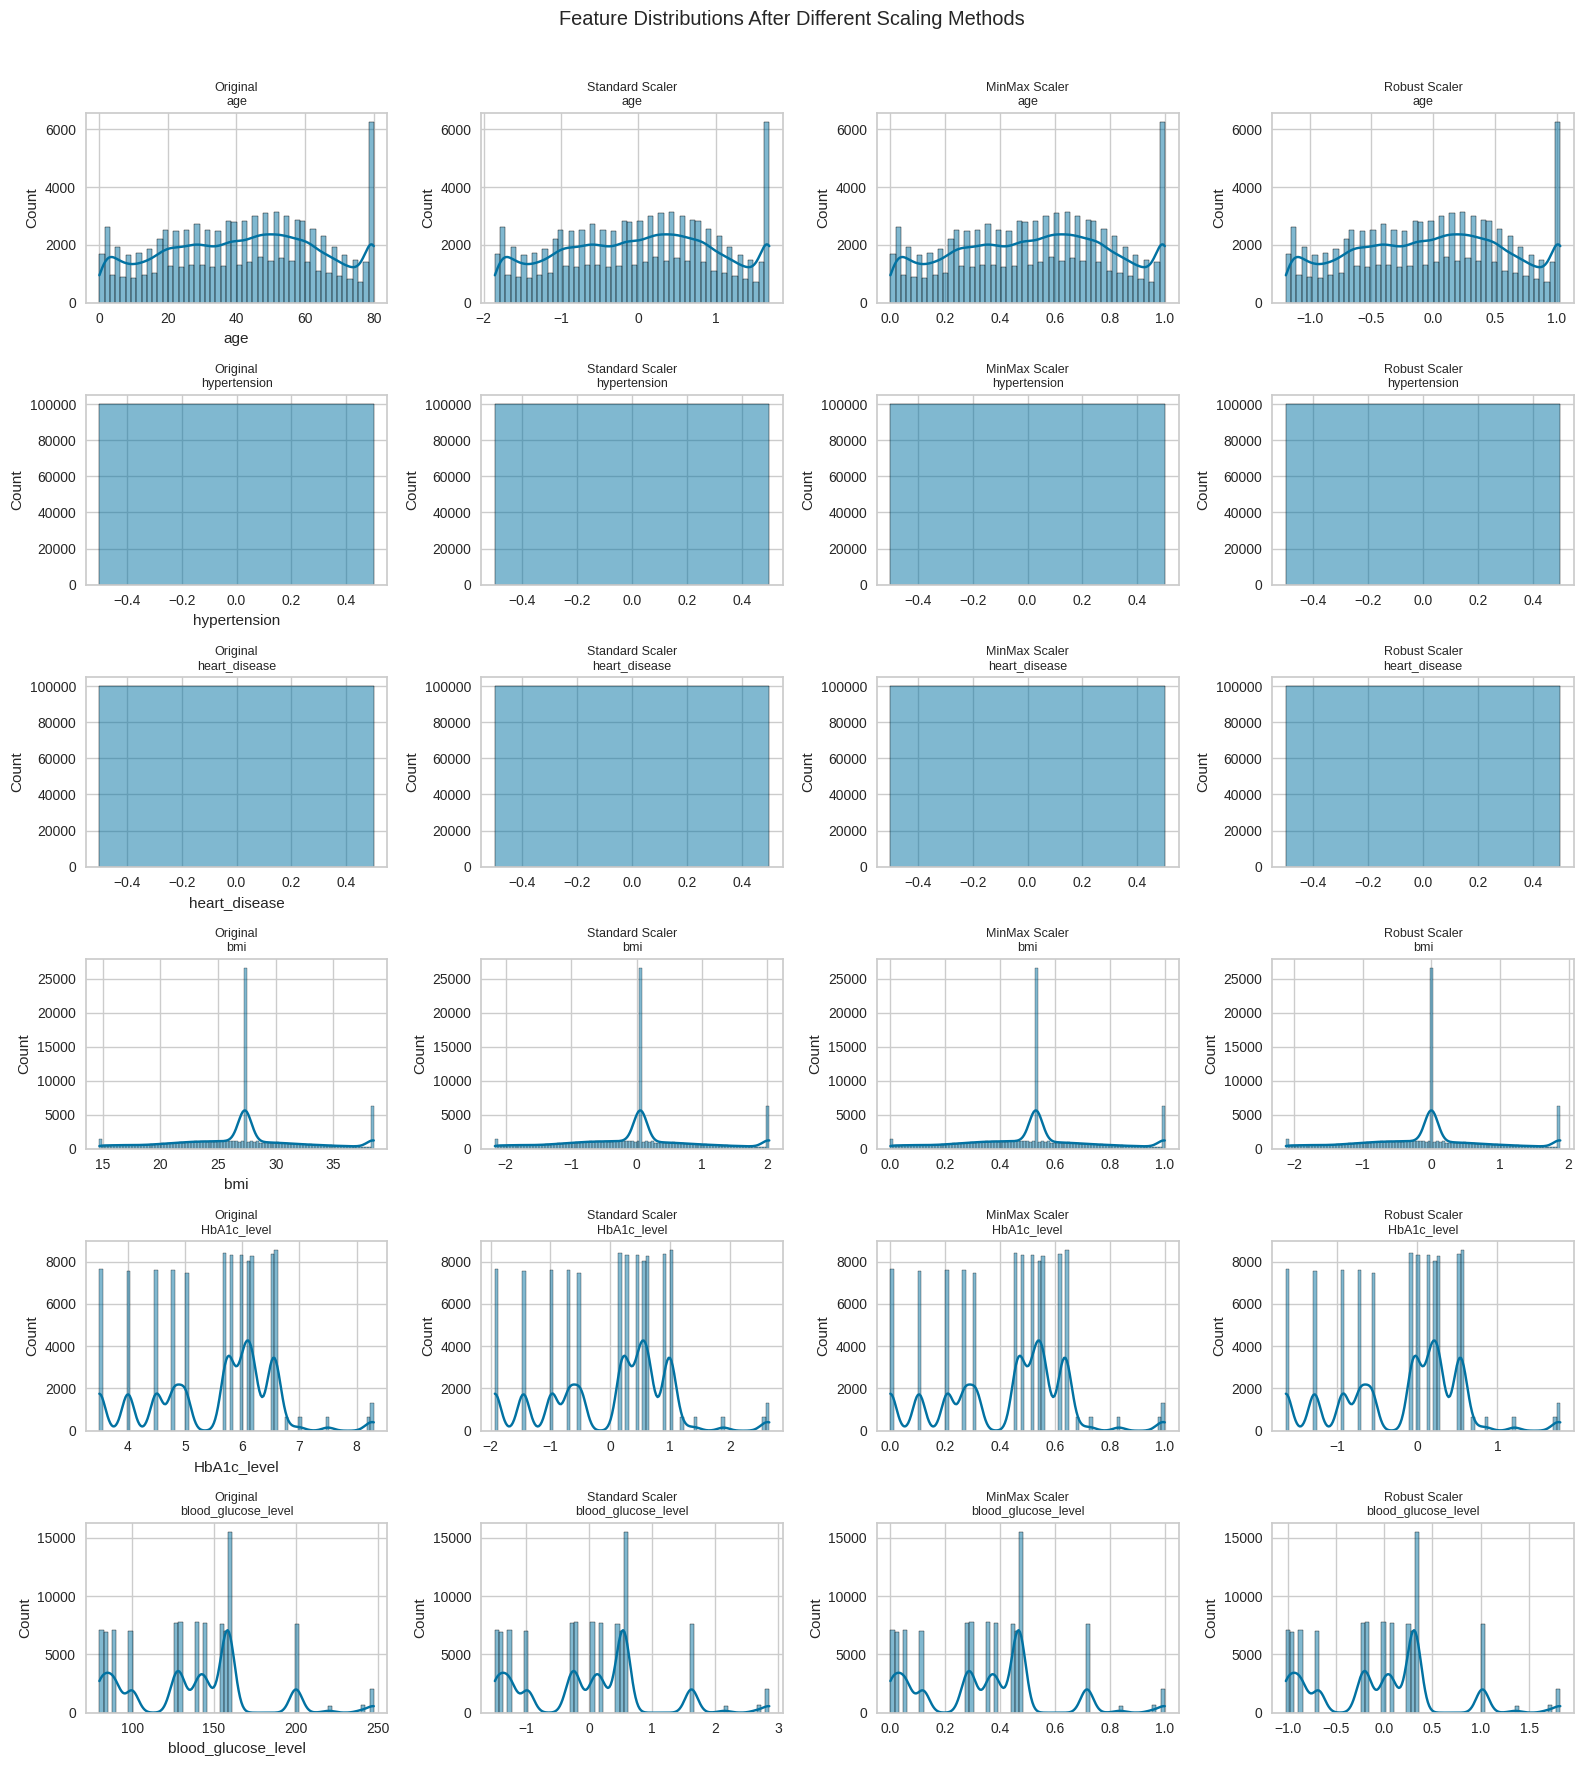

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

df_clean = df_winsor
target = 'diabetes'
X_all  = df_clean.drop(columns=[target])
y      = df_clean[target]

numeric_feats = X_all.select_dtypes(include='number').columns.tolist()
X_numeric     = X_all[numeric_feats]

scalers = {
    'Original':        None,
    'Standard Scaler': StandardScaler(),
    'MinMax Scaler':   MinMaxScaler(),
    'Robust Scaler':   RobustScaler()
}

n_feats = len(numeric_feats)
n_cols  = len(scalers)
plt.figure(figsize=(4 * n_cols, 3 * n_feats))
plot_idx = 1

for col in numeric_feats:
    for name, scaler in scalers.items():
        ax = plt.subplot(n_feats, n_cols, plot_idx)
        if scaler is None:
            data = X_numeric[col]
        else:
            data = scaler.fit_transform(X_numeric[[col]]).ravel()
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(f'{name}\n{col}', fontsize=9)
        plot_idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions After Different Scaling Methods', y=0.98)
plt.show()


scaler = StandardScaler()

#### 5. Feature Engineering

Create new features, select the most important ones, and reduce dimensionality to enhance model performance.

##### 5.1 Feature Creation

Generate new features based on domain knowledge and feature interactions.

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
New features added:


gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              0           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             0              0         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes BMI_Category  \
0          6.6                140.0         0            2   
1          6.6                 80.0         0            2   
2          5.7                158.0         0            2   
3          5.0                155.0         0            1   
4          4.8                155.0         0            1   

   Glucose_HbA1c_Ratio Age_Group  bmi_x_age  glucose_x_bmi  
0            21.212118         4    2015.20        3526.60  
1            12.121210         3    1475.28        2185.60  
2            27.719293         0     764.96        4316.56  
3            30.999994         1     844.20        3634.75  
4            32.291660         4    1530.64        3121.70

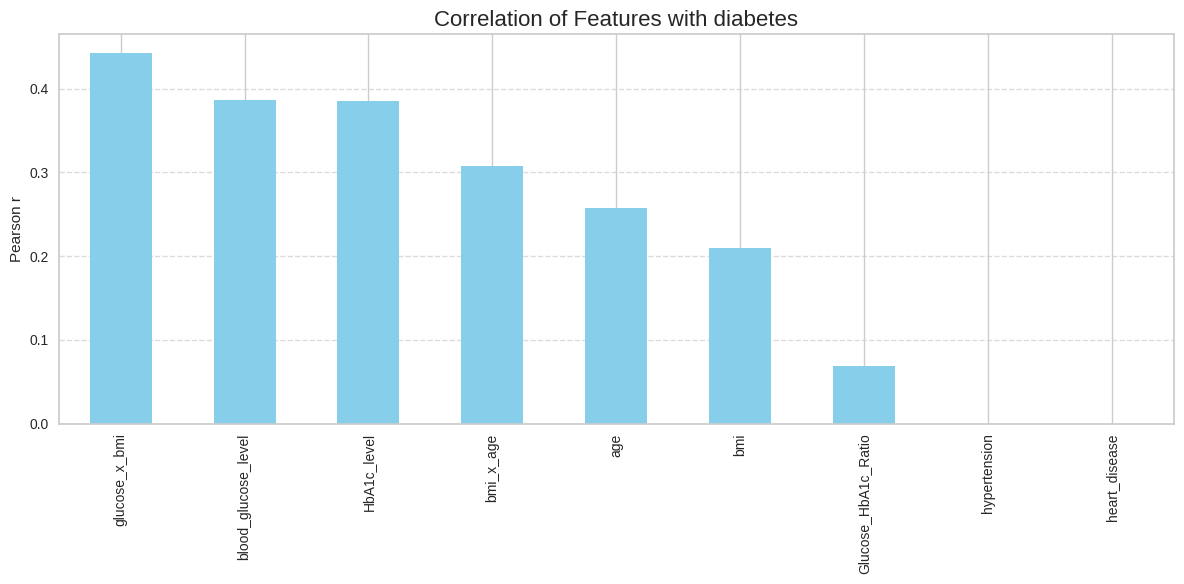

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_features = df_winsor.copy()

print("Columns:", df_features.columns.tolist())
target = 'diabetes'

df_features['BMI_Category'] = pd.cut(
    df_features['bmi'],
    bins=[0, 18.5, 25, 30, df_features['bmi'].max()],
    labels=[0, 1, 2, 3]  # 0=Underweight,1=Normal,2=Overweight,3=Obese
)

df_features['Glucose_HbA1c_Ratio'] = (
    df_features['blood_glucose_level']
    / (df_features['HbA1c_level'] + 1e-6)
)

df_features['Age_Group'] = pd.cut(
    df_features['age'],
    bins=[df_features['age'].min(), 30, 40, 50, 60, df_features['age'].max()],
    labels=[0, 1, 2, 3, 4]
)

df_features['bmi_x_age']     = df_features['bmi'] * df_features['age']
df_features['glucose_x_bmi'] = df_features['blood_glucose_level'] * df_features['bmi']

print("New features added:")
display(df_features.head())

numeric_corr = df_features.select_dtypes(include='number').corr()
corr_target = numeric_corr[target].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
corr_target.drop(target).plot(kind='bar', color='skyblue')
plt.title(f'Correlation of Features with {target}', fontsize=16)
plt.ylabel('Pearson r')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### 5.2 Feature Selection (RFECV)

Use Recursive Feature Elimination with Cross-Validation to select the most predictive features.

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'BMI_Category', 'Glucose_HbA1c_Ratio', 'Age_Group', 'bmi_x_age', 'glucose_x_bmi']
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Optimal number of features: 5
Feature ranking: {'age': np.int64(1), 'hypertension': np.int64(5), 'heart_disease': np.int64(4), 'bmi': np.int64(1), 'HbA1c_level': np.int64(1), 'blood_glucose_level': np.int64(1), 'Glucose_HbA1c_Ratio': np.int64(1), 'bmi_x_age': np.int64(2), 'glucose_x_bmi': np.int64(3)}


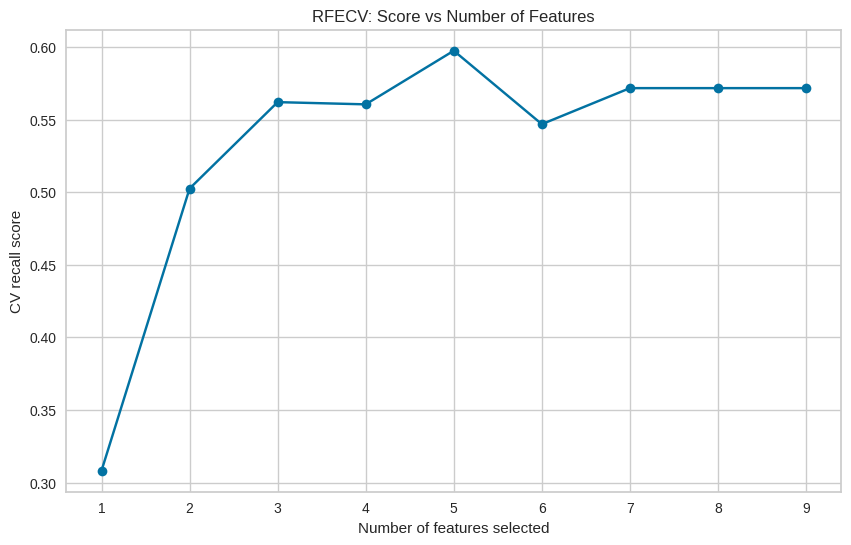

Selected features (5): ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'Glucose_HbA1c_Ratio']


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

print("Columns:", df_features.columns.tolist())
target = 'diabetes'

X_feat = df_features.drop(columns=[target])
y_feat = df_features[target]

X_num = X_feat.select_dtypes(include='number')

estimator = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector  = RFECV(
    estimator,
    step=1,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

selector.fit(X_num, y_feat)

print(f"Optimal number of features: {selector.n_features_}")
print("Feature ranking:", dict(zip(X_num.columns, selector.ranking_)))

scores = getattr(selector, "grid_scores_", selector.cv_results_["mean_test_score"])
plt.figure(figsize=(10,6))
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.xlabel('Number of features selected')
plt.ylabel('CV recall score')
plt.title('RFECV: Score vs Number of Features')
plt.grid(True)
plt.show()

selected = X_num.columns[selector.support_].tolist()
print(f"Selected features ({len(selected)}): {selected}")
X_selected = X_num[selected]

##### 5.3 Dimensionality Reduction (PCA)

Apply Principal Component Analysis to understand data structure and potentially reduce feature space.

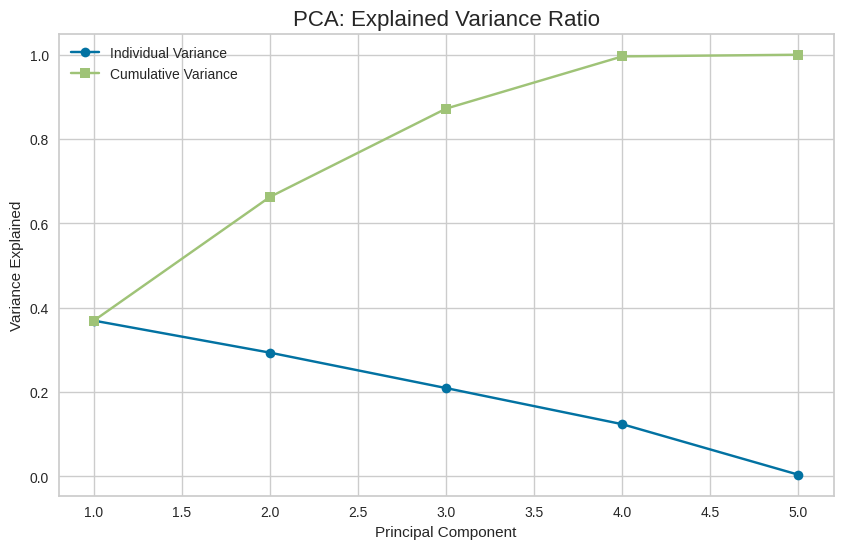

Number of components to retain 95% variance: 4


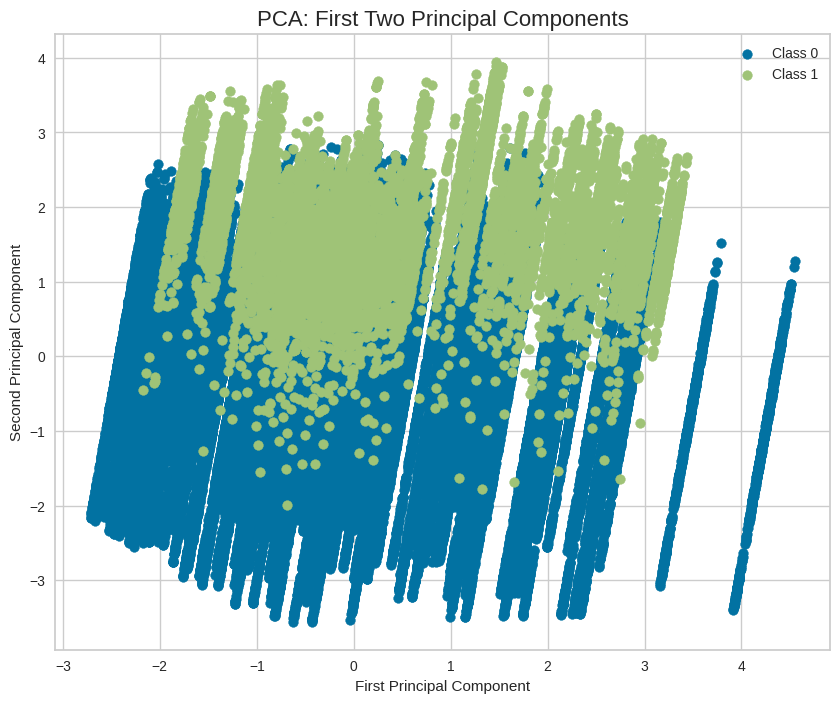

In [25]:

pca = PCA()
pca.fit(scaler.fit_transform(X_selected))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 's-')
plt.grid(True)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend(['Individual Variance', 'Cumulative Variance'])
plt.title('PCA: Explained Variance Ratio', fontsize=16)
plt.show()

# Determine number of components to retain 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(scaler.fit_transform(X_selected))

plt.figure(figsize=(10, 8))
for label in [0, 1]:
    plt.scatter(
        X_pca[y_feat == label, 0],
        X_pca[y_feat == label, 1],
        label=f"Class {label}"
    )
plt.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First Two Principal Components', fontsize=16)
plt.show()

#### 6. Train/Test Split, Scaling & SMOTE

Prepare data for modeling by splitting, scaling, and addressing class imbalance.

In [26]:

X_final = X_selected
y_final = y_feat

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())

Class distribution in training set:
diabetes
0    73200
1     6800
Name: count, dtype: int64

Class distribution in test set:
diabetes
0    18300
1     1700
Name: count, dtype: int64


Class distribution after SMOTE:
diabetes
1    73200
0    73200
Name: count, dtype: int64


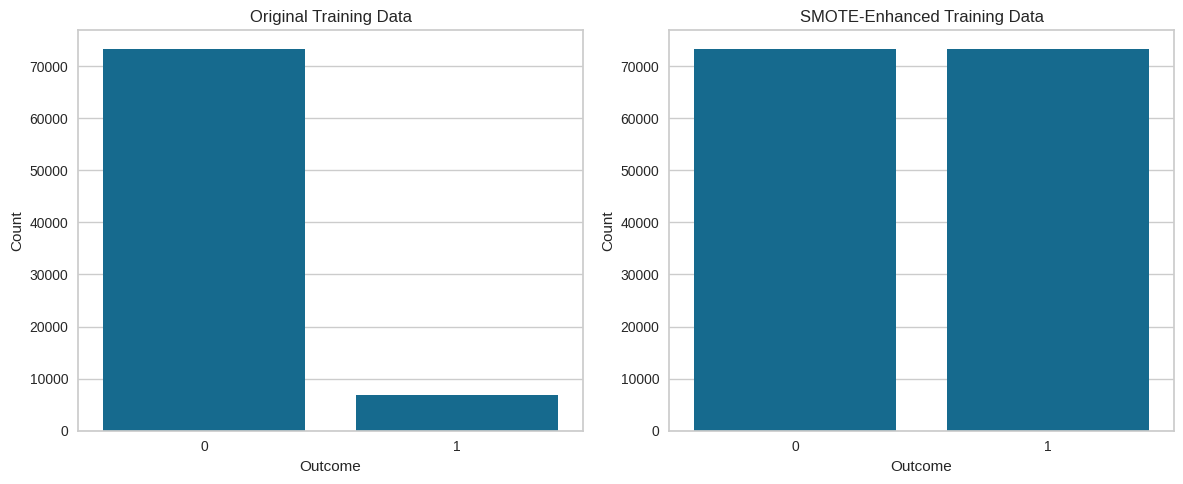

In [27]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Training Data')
plt.xlabel('Outcome')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('SMOTE-Enhanced Training Data')
plt.xlabel('Outcome')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Save Prepared Data

Save preprocessed data for use in model training.

In [28]:
import joblib

selected_features = X_selected.columns.tolist()

preprocessed_data = {
    'X_train_smote':      X_train_smote,
    'y_train_smote':      y_train_smote,
    'X_test_scaled':      X_test_scaled,
    'y_test':             y_test,
    'selected_features':  selected_features,
    'scaler':             scaler
}

joblib.dump(preprocessed_data, 'preprocessed_data.joblib')
print("Preprocessed data saved to 'preprocessed_data.joblib'")

Preprocessed data saved to 'preprocessed_data.joblib'


## Part 3: Model Training (Models 1–5)


### Models 1–5: Training and Tuning

Train and evaluate the first set of models: Logistic Regression, KNN, SVM, Naive Bayes, and Decision Tree.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

np.random.seed(42)

preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

print(f"Training data shape: {X_train_smote.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Selected features: {selected_features.tolist() if hasattr(selected_features, 'tolist') else selected_features}")

Training data shape: (146400, 5)
Test data shape: (20000, 5)
Selected features: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'Glucose_HbA1c_Ratio']


#### Model Training & Evaluation Functions

Standardized functions for model training and evaluation.

In [30]:
models_results = {}

def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

def train_evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, then print and store results"""
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = evaluate_model(y_test, y_pred, y_prob)

    print(f"{name} - Base Model:")
    print_metrics(metrics)

    return model, y_pred, y_prob, metrics

##### Logistic Regression

A simple yet effective baseline for binary classification.

In [31]:

lr = LogisticRegression(random_state=42, solver='liblinear')

lr_model, y_pred_lr, y_prob_lr, lr_metrics = train_evaluate_model(
    lr, "Logistic Regression", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Logistic Regression - Base Model:
Accuracy:  0.8773
Precision: 0.4004
Recall:    0.8912
F1 Score:  0.5525
ROC AUC:   0.9597


In [32]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, solver='liblinear'),
    param_grid_lr,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_lr.fit(X_train_smote, y_train_smote)

best_lr = grid_lr.best_estimator_
print("Best Logistic Regression parameters:", grid_lr.best_params_)

y_pred_best_lr = best_lr.predict(X_test_scaled)
y_prob_best_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
lr_best_metrics = evaluate_model(y_test, y_pred_best_lr, y_prob_best_lr)

print("\nLogistic Regression - Tuned Model:")
print_metrics(lr_best_metrics)

models_results['Logistic Regression'] = {
    'model': best_lr,
    'metrics': lr_best_metrics
}

Best Logistic Regression parameters: {'C': 0.001, 'class_weight': None, 'penalty': 'l2'}

Logistic Regression - Tuned Model:
Accuracy:  0.8645
Precision: 0.3761
Recall:    0.9029
F1 Score:  0.5310
ROC AUC:   0.9594


##### K-Nearest Neighbors (KNN)

A non-parametric algorithm that classifies based on the majority class of k-nearest neighbors.

In [ ]:

knn = KNeighborsClassifier()

knn_model, y_pred_knn, y_prob_knn, knn_metrics = train_evaluate_model(
    knn, "KNN", X_train_smote, y_train_smote, X_test_scaled, y_test
)

KNN - Base Model:
Accuracy:  0.9138
Precision: 0.4957
Recall:    0.8076
F1 Score:  0.6143
ROC AUC:   0.9096


In [34]:
# Hyperparameter tuning for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_knn.fit(X_train_smote, y_train_smote)

best_knn = grid_knn.best_estimator_
print("Best KNN parameters:", grid_knn.best_params_)

y_pred_best_knn = best_knn.predict(X_test_scaled)
y_prob_best_knn = best_knn.predict_proba(X_test_scaled)[:, 1]
knn_best_metrics = evaluate_model(y_test, y_pred_best_knn, y_prob_best_knn)

print("\nKNN - Tuned Model:")
print_metrics(knn_best_metrics)

models_results['KNN'] = {
    'model': best_knn,
    'metrics': knn_best_metrics
}

Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}

KNN - Tuned Model:
Accuracy:  0.9071
Precision: 0.4731
Recall:    0.8171
F1 Score:  0.5992
ROC AUC:   0.9251


##### Support Vector Machine (SVM)

Finds the optimal hyperplane for class separation.

In [ ]:

svm = SVC(probability=True, random_state=42)

svm_model, y_pred_svm, y_prob_svm, svm_metrics = train_evaluate_model(
    svm, "SVM", X_train_smote, y_train_smote, X_test_scaled, y_test
)

SVM - Base Model:
Accuracy:  0.8745
Precision: 0.3986
Recall:    0.9365
F1 Score:  0.5592
ROC AUC:   0.9720


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Hyperparameter distributions for SVM
param_dist_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'linear']
}

rand_svm = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_distributions=param_dist_svm,
    n_iter=10,
    cv=5,
    scoring='recall',
    random_state=42,
    n_jobs=-1
)

rand_svm.fit(X_train_smote, y_train_smote)

best_svm = rand_svm.best_estimator_
print("Best SVM parameters:", rand_svm.best_params_)

y_pred_best_svm = best_svm.predict(X_test_scaled)
y_prob_best_svm = best_svm.predict_proba(X_test_scaled)[:, 1]
svm_best_metrics = evaluate_model(y_test, y_pred_best_svm, y_prob_best_svm)

print("\nSVM - Tuned Model (RandomizedSearchCV):")
print_metrics(svm_best_metrics)

models_results['SVM'] = {
    'model': best_svm,
    'metrics': svm_best_metrics
}


KeyboardInterrupt: 

##### Naive Bayes

Probabilistic classifier based on Bayes' theorem with strong independence assumptions.

In [37]:
gnb = GaussianNB()
bnb = BernoulliNB()

gnb_model, y_pred_gnb, y_prob_gnb, gnb_metrics = train_evaluate_model(
    gnb, "Gaussian Naive Bayes", X_train_smote, y_train_smote, X_test_scaled, y_test
)

bnb_model, y_pred_bnb, y_prob_bnb, bnb_metrics = train_evaluate_model(
    bnb, "Bernoulli Naive Bayes", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Gaussian Naive Bayes - Base Model:
Accuracy:  0.8712
Precision: 0.3872
Recall:    0.8835
F1 Score:  0.5384
ROC AUC:   0.9529
Bernoulli Naive Bayes - Base Model:
Accuracy:  0.7702
Precision: 0.2538
Recall:    0.8776
F1 Score:  0.3937
ROC AUC:   0.8931


In [38]:
if gnb_metrics['roc_auc'] > bnb_metrics['roc_auc']:
    best_nb = gnb
    nb_best_metrics = gnb_metrics
    nb_variant = "Gaussian"
else:
    best_nb = bnb
    nb_best_metrics = bnb_metrics
    nb_variant = "Bernoulli"

print(f"Best Naive Bayes variant: {nb_variant}")

models_results['Naive Bayes'] = {
    'model': best_nb,
    'metrics': nb_best_metrics
}

Best Naive Bayes variant: Gaussian


##### Decision Tree

Predicts the target by learning simple decision rules from features.

In [ ]:

dt = DecisionTreeClassifier(random_state=42)

dt_model, y_pred_dt, y_prob_dt, dt_metrics = train_evaluate_model(
    dt, "Decision Tree", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Decision Tree - Base Model:
Accuracy:  0.9504
Precision: 0.6987
Recall:    0.7312
F1 Score:  0.7146
ROC AUC:   0.8573


In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

param_dist_dt = {
    'max_depth':        [3, 5, 7, 9, None],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion':        ['gini', 'entropy']
}

rand_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_dt.fit(X_train_smote, y_train_smote)

best_dt = rand_dt.best_estimator_
print("Best Decision Tree params (random search):", rand_dt.best_params_)

y_pred_dt  = best_dt.predict(X_test_scaled)
y_prob_dt  = best_dt.predict_proba(X_test_scaled)[:, 1]
dt_metrics = evaluate_model(y_test, y_pred_dt, y_prob_dt)

print("\nDecision Tree – Tuned (RandomizedSearchCV):")
print_metrics(dt_metrics)

models_results['Decision Tree'] = {
    'model':   best_dt,
    'metrics': dt_metrics
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Decision Tree params (random search): {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy'}

Decision Tree – Tuned (RandomizedSearchCV):
Accuracy:  0.8025
Precision: 0.2982
Recall:    0.9776
F1 Score:  0.4570
ROC AUC:   0.9607


#### Initial Model Comparison

Compare the performance of the first set of models.

In [41]:
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

results_df = results_df.sort_values('recall', ascending=False)

print("Model Performance Comparison:")
display(results_df)

joblib.dump(models_results, 'models_results_part1.joblib')
print("First set of models saved to 'models_results_part1.joblib'")

Model Performance Comparison:


accuracy  precision    recall        f1   roc_auc
Decision Tree         0.80250   0.298170  0.977647  0.456970  0.960650
Logistic Regression   0.86445   0.376133  0.902941  0.531050  0.959351
Naive Bayes           0.87125   0.387213  0.883529  0.538448  0.952911
KNN                   0.90710   0.473093  0.817059  0.599223  0.925051

First set of models saved to 'models_results_part1.joblib'


## Part 4: Model Training (Models 6–10)


### Models 6–10: Ensemble Methods

Train and tune ensemble models: Random Forest, Gradient Boosting, AdaBoost, Extra Trees, and Bagging Classifier.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)

np.random.seed(42)

preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

try:
    models_results = joblib.load('models_results_part1.joblib')
    print("Previous models loaded successfully.")
except:
    models_results = {}
    print("Starting with fresh models dictionary.")

Previous models loaded successfully.


#### Model Training & Evaluation Functions

Reusable functions for model evaluation.

In [43]:
def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

def train_evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, then print and store results"""
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = evaluate_model(y_test, y_pred, y_prob)

    print(f"{name} - Base Model:")
    print_metrics(metrics)

    return model, y_pred, y_prob, metrics

##### Random Forest

An ensemble of decision trees using bagging and feature randomness.

In [44]:

rf = RandomForestClassifier(random_state=42)

rf_model, y_pred_rf, y_prob_rf, rf_metrics = train_evaluate_model(
    rf, "Random Forest", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Random Forest - Base Model:
Accuracy:  0.9584
Precision: 0.7666
Recall:    0.7341
F1 Score:  0.7500
ROC AUC:   0.9575


In [ ]:
# Hyperparameter tuning for Random Forest
param_dist_rf = {
    'n_estimators':      [50, 100, 200],
    'max_depth':         [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'bootstrap':         [True, False]
}

rand_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_rf.fit(X_train_smote, y_train_smote)

best_rf = rand_rf.best_estimator_
print("Best RF params (random search):", rand_rf.best_params_)

y_pred_rf  = best_rf.predict(X_test_scaled)
y_prob_rf  = best_rf.predict_proba(X_test_scaled)[:, 1]
rf_metrics = evaluate_model(y_test, y_pred_rf, y_prob_rf)

print("\nRandom Forest – Tuned (RandomizedSearchCV):")
print_metrics(rf_metrics)

models_results['Random Forest'] = {
    'model':   best_rf,
    'metrics': rf_metrics
}



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF params (random search): {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Random Forest – Tuned (RandomizedSearchCV):
Accuracy:  0.9591
Precision: 0.7765
Recall:    0.7294
F1 Score:  0.7522
ROC AUC:   0.9512


##### Gradient Boosting

Sequentially builds trees to correct errors of previous ones.

In [ ]:

gb = GradientBoostingClassifier(random_state=42)

gb_model, y_pred_gb, y_prob_gb, gb_metrics = train_evaluate_model(
    gb, "Gradient Boosting", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Gradient Boosting - Base Model:
Accuracy:  0.9410
Precision: 0.6127
Recall:    0.8318
F1 Score:  0.7056
ROC AUC:   0.9773


In [ ]:
# Hyperparameter tuning for Gradient Boosting
param_dist_gb = {
    'learning_rate':    [0.01, 0.05, 0.1],
    'n_estimators':     [100, 200],
    'max_depth':        [3, 5, 7],
    'min_samples_split':[2, 5],
    'subsample':        [0.8, 1.0]
}

rand_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_gb.fit(X_train_smote, y_train_smote)

best_gb = rand_gb.best_estimator_
print("Best Gradient Boosting params (random search):", rand_gb.best_params_)

y_pred_gb = best_gb.predict(X_test_scaled)
y_prob_gb = best_gb.predict_proba(X_test_scaled)[:, 1]
gb_metrics = evaluate_model(y_test, y_pred_gb, y_prob_gb)

print("\nGradient Boosting – Tuned (RandomizedSearchCV):")
print_metrics(gb_metrics)

models_results['Gradient Boosting'] = {
    'model':   best_gb,
    'metrics': gb_metrics
}


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Gradient Boosting params (random search): {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.1}

Gradient Boosting – Tuned (RandomizedSearchCV):
Accuracy:  0.9636
Precision: 0.8092
Recall:    0.7482
F1 Score:  0.7775
ROC AUC:   0.9769


##### AdaBoost

Combines weak learners sequentially, focusing on misclassified instances.

In [ ]:

ada = AdaBoostClassifier(random_state=42)

ada_model, y_pred_ada, y_prob_ada, ada_metrics = train_evaluate_model(
    ada, "AdaBoost", X_train_smote, y_train_smote, X_test_scaled, y_test
)

AdaBoost - Base Model:
Accuracy:  0.8706
Precision: 0.3897
Recall:    0.9229
F1 Score:  0.5480
ROC AUC:   0.9718


In [ ]:
# Hyperparameter tuning for AdaBoost
param_dist_ada = {
    'n_estimators':   [50, 100, 200],
    'learning_rate':  [0.01, 0.1, 1.0],
    'algorithm':      ['SAMME', 'SAMME.R']
}

rand_ada = RandomizedSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_distributions=param_dist_ada,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_ada.fit(X_train_smote, y_train_smote)

best_ada = rand_ada.best_estimator_
print("Best AdaBoost params (random search):", rand_ada.best_params_)

y_pred_ada  = best_ada.predict(X_test_scaled)
y_prob_ada  = best_ada.predict_proba(X_test_scaled)[:, 1]
ada_metrics = evaluate_model(y_test, y_pred_ada, y_prob_ada)

print("\nAdaBoost – Tuned (RandomizedSearchCV):")
print_metrics(ada_metrics)

models_results['AdaBoost'] = {
    'model':   best_ada,
    'metrics': ada_metrics
}



Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Best AdaBoost params (random search): {'n_estimators': 200, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

AdaBoost – Tuned (RandomizedSearchCV):
Accuracy:  0.8714
Precision: 0.3916
Recall:    0.9253
F1 Score:  0.5503
ROC AUC:   0.9719


##### Extra Trees

An ensemble method similar to Random Forest with additional randomization.

In [ ]:

et = ExtraTreesClassifier(random_state=42)

et_model, y_pred_et, y_prob_et, et_metrics = train_evaluate_model(
    et, "Extra Trees", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Extra Trees - Base Model:
Accuracy:  0.9587
Precision: 0.7735
Recall:    0.7271
F1 Score:  0.7495
ROC AUC:   0.9361


In [ ]:
# Hyperparameter tuning for Extra Trees
param_dist_et = {
    'n_estimators':      [100, 200],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2]
}

rand_et = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(random_state=42),
    param_distributions=param_dist_et,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_et.fit(X_train_smote, y_train_smote)

best_et = rand_et.best_estimator_
print("Best Extra Trees params (random search):", rand_et.best_params_)

y_pred_et = best_et.predict(X_test_scaled)
y_prob_et = best_et.predict_proba(X_test_scaled)[:, 1]
et_metrics = evaluate_model(y_test, y_pred_et, y_prob_et)

print("\nExtra Trees – Tuned (RandomizedSearchCV):")
print_metrics(et_metrics)

models_results['Extra Trees'] = {
    'model':   best_et,
    'metrics': et_metrics
}


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Extra Trees params (random search): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Extra Trees – Tuned (RandomizedSearchCV):
Accuracy:  0.9585
Precision: 0.7719
Recall:    0.7265
F1 Score:  0.7485
ROC AUC:   0.9392


##### Bagging Classifier

Fits base classifiers on random subsets of the dataset.

In [ ]:

bag = BaggingClassifier(random_state=42)

bag_model, y_pred_bag, y_prob_bag, bag_metrics = train_evaluate_model(
    bag, "Bagging Classifier", X_train_smote, y_train_smote, X_test_scaled, y_test
)

Bagging Classifier - Base Model:
Accuracy:  0.9580
Precision: 0.7659
Recall:    0.7294
F1 Score:  0.7472
ROC AUC:   0.9293


In [ ]:
# Hyperparameter tuning for Bagging Classifier
param_dist_bag = {
    'n_estimators':        [10, 20, 50],
    'max_samples':         [0.5, 0.7, 1.0],
    'max_features':        [0.5, 0.7, 1.0],
    'bootstrap':           [True, False],
    'bootstrap_features':  [True, False]
}

rand_bag = RandomizedSearchCV(
    estimator=BaggingClassifier(random_state=42),
    param_distributions=param_dist_bag,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_bag.fit(X_train_smote, y_train_smote)

best_bag = rand_bag.best_estimator_
print("Best Bagging params (random search):", rand_bag.best_params_)

y_pred_bag = best_bag.predict(X_test_scaled)
y_prob_bag = best_bag.predict_proba(X_test_scaled)[:, 1]
bag_metrics = evaluate_model(y_test, y_pred_bag, y_prob_bag)

print("\nBagging Classifier – Tuned (RandomizedSearchCV):")
print_metrics(bag_metrics)

models_results['Bagging Classifier'] = {
    'model':   best_bag,
    'metrics': bag_metrics
}



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Bagging params (random search): {'n_estimators': 50, 'max_samples': 0.7, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False}

Bagging Classifier – Tuned (RandomizedSearchCV):
Accuracy:  0.9675
Precision: 0.8930
Recall:    0.7018
F1 Score:  0.7859
ROC AUC:   0.9650


#### Model Comparison

Compare the performance of the second set of models.

In [54]:
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

results_df = results_df.sort_values('recall', ascending=False)

print("Model Performance Comparison:")
display(results_df)

joblib.dump(models_results, 'models_results_part2.joblib')
print("Models saved to 'models_results_part2.joblib'")

Model Performance Comparison:


accuracy  precision    recall        f1   roc_auc
Decision Tree         0.80250   0.298170  0.977647  0.456970  0.960650
AdaBoost              0.87145   0.391586  0.925294  0.550289  0.971948
Logistic Regression   0.86445   0.376133  0.902941  0.531050  0.959351
Naive Bayes           0.87125   0.387213  0.883529  0.538448  0.952911
KNN                   0.90710   0.473093  0.817059  0.599223  0.925051
Gradient Boosting     0.96360   0.809160  0.748235  0.777506  0.976869
Random Forest         0.95915   0.776456  0.729412  0.752199  0.951211
Extra Trees           0.95850   0.771875  0.726471  0.748485  0.939210
Bagging Classifier    0.96750   0.892964  0.701765  0.785903  0.964991

Models saved to 'models_results_part2.joblib'


## Part 5: Advanced Gradient Boosting Models


### Models 11–13: XGBoost, LightGBM, CatBoost

Train and tune advanced gradient boosting models.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

np.random.seed(42)

preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

try:
    models_results = joblib.load('models_results_part2.joblib')
    print("Previous models loaded successfully.")
except:
    models_results = {}
    print("Starting with fresh models dictionary.")

Previous models loaded successfully.


#### Model Training & Evaluation Functions

Reusable functions for advanced models.

In [56]:
def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

def train_evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, then print and store results"""
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = evaluate_model(y_test, y_pred, y_prob)

    print(f"{name} - Base Model:")
    print_metrics(metrics)

    return model, y_pred, y_prob, metrics

##### XGBoost

Optimized gradient boosting implementation for speed and performance.

In [ ]:

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_fit, y_pred_xgb, y_prob_xgb, xgb_metrics = train_evaluate_model(
    xgb_model, "XGBoost", X_train_smote, y_train_smote, X_test_scaled, y_test
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Base Model:
Accuracy:  0.9611
Precision: 0.7903
Recall:    0.7382
F1 Score:  0.7634
ROC AUC:   0.9755


In [ ]:
# Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'learning_rate':    [0.01, 0.1, 0.2],
    'max_depth':        [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma':            [0, 0.1, 0.2],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators':     [100, 200]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_xgb.fit(X_train_smote, y_train_smote)

best_xgb = rand_xgb.best_estimator_
print("Best XGBoost params (random search):", rand_xgb.best_params_)

y_pred_xgb = best_xgb.predict(X_test_scaled)
y_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

print("\nXGBoost – Tuned (RandomizedSearchCV):")
print_metrics(xgb_metrics)

models_results['XGBoost'] = {
    'model':   best_xgb,
    'metrics': xgb_metrics
}


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:45:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost params (random search): {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

XGBoost – Tuned (RandomizedSearchCV):
Accuracy:  0.9604
Precision: 0.7719
Recall:    0.7582
F1 Score:  0.7650
ROC AUC:   0.9757


##### LightGBM

Efficient gradient boosting framework for speed and memory.

In [59]:

lgbm = lgb.LGBMClassifier(random_state=42)

lgbm_fit, y_pred_lgbm, y_prob_lgbm, lgbm_metrics = train_evaluate_model(
    lgbm, "LightGBM", X_train_smote, y_train_smote, X_test_scaled, y_test
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73200, number of negative: 73200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 146400, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - Base Model:
Accuracy:  0.9658
Precision: 0.8401
Recall:    0.7388
F1 Score:  0.7862
ROC AUC:   0.9765


In [ ]:
# Hyperparameter tuning for LightGBM
param_dist_lgbm = {
    'learning_rate':     [0.01, 0.1, 0.2],
    'n_estimators':      [100, 200, 300],
    'num_leaves':        [31, 50, 100],
    'max_depth':         [-1, 5, 10],
    'min_child_samples': [20, 50]
}

rand_lgbm = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_lgbm.fit(X_train_smote, y_train_smote)

best_lgbm = rand_lgbm.best_estimator_
print("Best LightGBM params (random search):", rand_lgbm.best_params_)

y_pred_lgbm = best_lgbm.predict(X_test_scaled)
y_prob_lgbm = best_lgbm.predict_proba(X_test_scaled)[:, 1]
lgbm_metrics = evaluate_model(y_test, y_pred_lgbm, y_prob_lgbm)

print("\nLightGBM – Tuned (RandomizedSearchCV):")
print_metrics(lgbm_metrics)

models_results['LightGBM'] = {
    'model':   best_lgbm,
    'metrics': lgbm_metrics
}


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73200, number of negative: 73200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 146400, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM – Tuned (RandomizedSearchCV):
Accuracy:  0.9657
Precision: 0.8536
Recall:    0.7200
F1 Score:  0.7811
ROC AUC:   0.9723


##### CatBoost

Gradient boosting library specialized for categorical features.

In [ ]:

catb = CatBoostClassifier(random_state=42, verbose=0)

catb_fit, y_pred_catb, y_prob_catb, catb_metrics = train_evaluate_model(
    catb, "CatBoost", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
# Hyperparameter tuning for CatBoost
param_dist_catb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth':         [4, 6, 8],
    'iterations':    [100, 200, 300],
    'l2_leaf_reg':   [1, 3, 5],
    'border_count':  [32, 64, 128]
}

rand_catb = RandomizedSearchCV(
    estimator=CatBoostClassifier(random_state=42, verbose=0),
    param_distributions=param_dist_catb,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_catb.fit(X_train_smote, y_train_smote)

best_catb = rand_catb.best_estimator_
print("Best CatBoost params (random search):", rand_catb.best_params_)

y_pred_catb = best_catb.predict(X_test_scaled)
y_prob_catb = best_catb.predict_proba(X_test_scaled)[:, 1]
catb_metrics = evaluate_model(y_test, y_pred_catb, y_prob_catb)

print("\nCatBoost – Tuned (RandomizedSearchCV):")
print_metrics(catb_metrics)

models_results['CatBoost'] = {
    'model':   best_catb,
    'metrics': catb_metrics
}


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CatBoost params (random search): {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8, 'border_count': 128}

CatBoost – Tuned (RandomizedSearchCV):
Accuracy:  0.9665
Precision: 0.8732
Recall:    0.7088
F1 Score:  0.7825
ROC AUC:   0.9760


#### Feature Importance

Analyze feature importance from gradient boosting models.

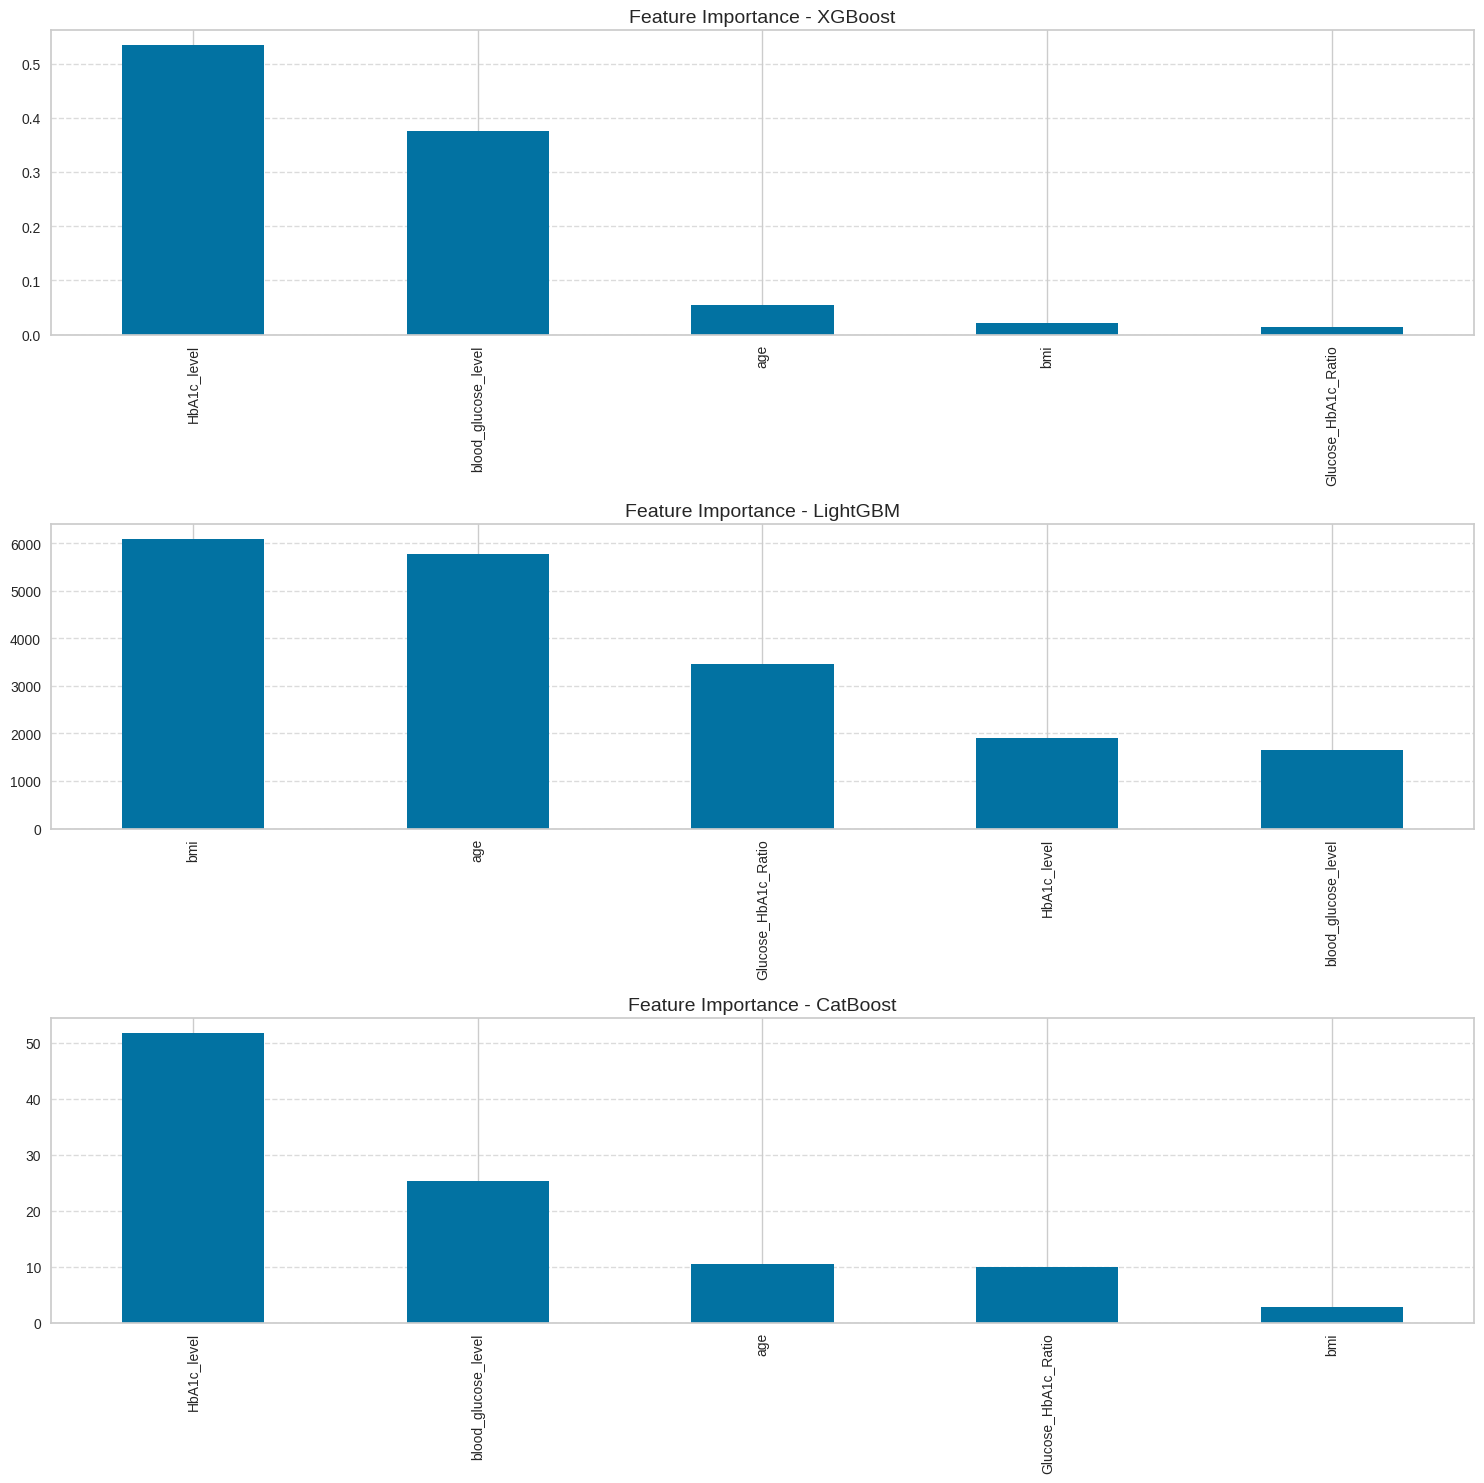

In [63]:
gb_models = {
    'XGBoost': best_xgb,
    'LightGBM': best_lgbm,
    'CatBoost': best_catb
}

plt.figure(figsize=(15, 15))
counter = 1

for model_name, model in gb_models.items():
    plt.subplot(3, 1, counter)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_

    feat_importances = pd.Series(importances, index=selected_features)
    feat_importances = feat_importances.sort_values(ascending=False)

    feat_importances.plot(kind='bar')
    plt.title(f'Feature Importance - {model_name}', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    counter += 1

plt.show()

#### Advanced Models Comparison

Compare the performance of advanced gradient boosting models.

In [ ]:
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

results_df = results_df.sort_values('recall', ascending=False)

print("Model Performance Comparison:")
display(results_df)

joblib.dump(models_results, 'models_results_part3.joblib')
print("Models saved to 'models_results_part3.joblib'")

Model Performance Comparison:


accuracy  precision    recall        f1   roc_auc
Decision Tree         0.80250   0.298170  0.977647  0.456970  0.960650
AdaBoost              0.87145   0.391586  0.925294  0.550289  0.971948
Logistic Regression   0.86445   0.376133  0.902941  0.531050  0.959351
Naive Bayes           0.87125   0.387213  0.883529  0.538448  0.952911
KNN                   0.90710   0.473093  0.817059  0.599223  0.925051
XGBoost               0.96040   0.771856  0.758235  0.764985  0.975653
Gradient Boosting     0.96360   0.809160  0.748235  0.777506  0.976869
Random Forest         0.95915   0.776456  0.729412  0.752199  0.951211
Extra Trees           0.95850   0.771875  0.726471  0.748485  0.939210
LightGBM              0.96570   0.853556  0.720000  0.781110  0.972293
CatBoost              0.96650   0.873188  0.708824  0.782468  0.975981
Bagging Classifier    0.96750   0.892964  0.701765  0.785903  0.964991

Models saved to 'models_results_part3.joblib'


## Part 6: Deep Learning Models


### Deep Learning for Diabetes Prediction

Train and evaluate neural network models for diabetes classification.

In [65]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

try:
    models_results = joblib.load('models_results_part3.joblib')
    print("Previous models loaded successfully.")
except:
    models_results = {}
    print("Starting with fresh models dictionary.")

Previous models loaded successfully.


#### Model Evaluation Function

Standardized evaluation for neural network models.

In [66]:
def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

##### Simple Neural Network

A basic neural network with a few dense layers.

In [ ]:
def create_simple_nn(input_shape):
    model = Sequential([
        Dense(64, activation='relu, input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model

simple_nn = create_simple_nn(X_train_smote.shape[1])
simple_nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 192 (768.00 B)

In [68]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'simple_nn_best.h5',
    monitor='val_recall',
    save_best_only=True,
    mode='max'
)

history_simple = simple_nn.fit(
    X_train_smote, y_train_smote,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/50
3643/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - auc: 0.9480 - loss: 0.2745 - recall: 0.8261

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8679 - auc: 0.9480 - loss: 0.2743 - recall: 0.8261 - val_accuracy: 0.8681 - val_auc: 0.0000e+00 - val_loss: 0.2953 - val_recall: 0.8681
Epoch 2/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8866 - auc: 0.9638 - loss: 0.2274 - recall: 0.8395 - val_accuracy: 0.8644 - val_auc: 0.0000e+00 - val_loss: 0.2869 - val_recall: 0.8644
Epoch 3/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8912 - auc: 0.9664 - loss: 0.2183 - recall: 0.8497 - val_accuracy: 0.8638 - val_auc: 0.0000e+00 - val_loss: 0.2909 - val_recall: 0.8638
Epoch 4/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8930 - auc: 0.9681 - loss: 0.2117 - recall: 0.8481 - val_accuracy: 0.8537 - val_auc: 0.0000e+00 - val_loss: 0.2884 - val_recall: 0.8537
Epoch 5/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8965 - auc: 0.9696 - loss: 0.2062 - recall: 0.8514 - val_accuracy: 0.8425 - val_auc: 0.0000e+00 - val_loss: 0.2927 - val_r

In [69]:
simple_nn = keras.models.load_model('simple_nn_best.h5')  # Load best model
y_pred_simple_nn = (simple_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_prob_simple_nn = simple_nn.predict(X_test_scaled).flatten()

simple_nn_metrics = evaluate_model(y_test, y_pred_simple_nn, y_prob_simple_nn)

print("Simple Neural Network - Performance Metrics:")
print_metrics(simple_nn_metrics)

models_results['Simple Neural Network'] = {
    'model': 'simple_nn_best.h5',  # Store filename instead of model object
    'metrics': simple_nn_metrics
}

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Simple Neural Network - Performance Metrics:
Accuracy:  0.9140
Precision: 0.4965
Recall:    0.8735
F1 Score:  0.6331
ROC AUC:   0.9727


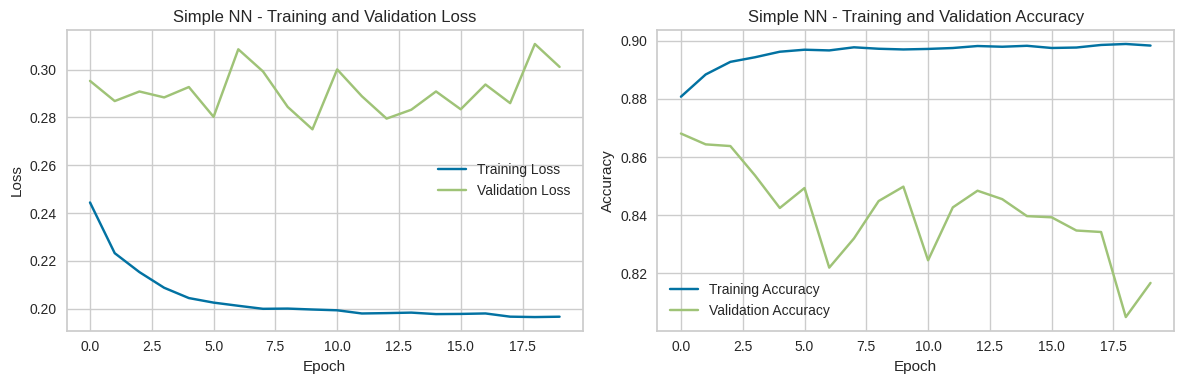

In [70]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_simple.history['loss'], label='Training Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title('Simple NN - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_simple.history['accuracy'], label='Training Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple NN - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Deep Neural Network

A deeper neural network with more layers and complexity.

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def create_deep_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

# build & inspect
deep_nn = create_deep_nn(X_train_smote.shape[1])
deep_nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,609 (49.25 KB)

 Trainable params: 12,129 (47.38 KB)

 Non-trainable params: 480 (1.88 KB)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_recall',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
checkpoint = ModelCheckpoint(
    'deep_nn_best.h5',
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_deep = deep_nn.fit(
    X_train_smote, y_train_smote,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

deep_nn.save('deep_nn_best.h5')
print("✅ Saved best deep‑NN to 'deep_nn_best.h5'")

Epoch 1/100
1814/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - auc: 0.9161 - loss: 0.3503 - recall: 0.8024
Epoch 1: val_recall improved from -inf to 0.84436, saving model to deep_nn_best.h5


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8351 - auc: 0.9163 - loss: 0.3497 - recall: 0.8025 - val_accuracy: 0.8444 - val_auc: 0.0000e+00 - val_loss: 0.2967 - val_recall: 0.8444
Epoch 2/100
1829/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8806 - auc: 0.9599 - loss: 0.2409 - recall: 0.8293
Epoch 2: val_recall improved from 0.84436 to 0.85707, saving model to deep_nn_best.h5


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8806 - auc: 0.9599 - loss: 0.2409 - recall: 0.8293 - val_accuracy: 0.8571 - val_auc: 0.0000e+00 - val_loss: 0.2943 - val_recall: 0.8571
Epoch 3/100
1825/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8837 - auc: 0.9624 - loss: 0.2320 - recall: 0.8361
Epoch 3: val_recall improved from 0.85707 to 0.86547, saving model to deep_nn_best.h5


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8837 - auc: 0.9624 - loss: 0.2320 - recall: 0.8361 - val_accuracy: 0.8655 - val_auc: 0.0000e+00 - val_loss: 0.2863 - val_recall: 0.8655
Epoch 4/100
1827/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8881 - auc: 0.9647 - loss: 0.2247 - recall: 0.8380
Epoch 4: val_recall did not improve from 0.86547
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8881 - auc: 0.9647 - loss: 0.2247 - recall: 0.8380 - val_accuracy: 0.8503 - val_auc: 0.0000e+00 - val_loss: 0.2914 - val_recall: 0.8503
Epoch 5/100
1825/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8897 - auc: 0.9659 - loss: 0.2191 - recall: 0.8359
Epoch 5: val_recall did not improve from 0.86547
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8897 - auc: 0.9659 - loss: 0.2191 - recall: 0.8359 - val_accuracy: 0.8457 - val_auc: 0.0000e+00 - val_loss: 0.2788 - val_recall: 0.8457
Epoch 6/100
1825/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8899 - auc: 

✅ Saved best deep‑NN to 'deep_nn_best.h5'


In [73]:
import tensorflow as tf
from tensorflow import keras

deep_nn = keras.models.load_model('deep_nn_best.h5')

y_pred_deep_nn = (deep_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_prob_deep_nn = deep_nn.predict(X_test_scaled).flatten()

deep_nn_metrics = evaluate_model(y_test, y_pred_deep_nn, y_prob_deep_nn)
print("Deep Neural Network - Performance Metrics:")
print_metrics(deep_nn_metrics)

models_results['Deep Neural Network'] = {
    'model': 'deep_nn_best.h5',
    'metrics': deep_nn_metrics
}

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Deep Neural Network - Performance Metrics:
Accuracy:  0.9154
Precision: 0.5014
Recall:    0.8641
F1 Score:  0.6346
ROC AUC:   0.9737


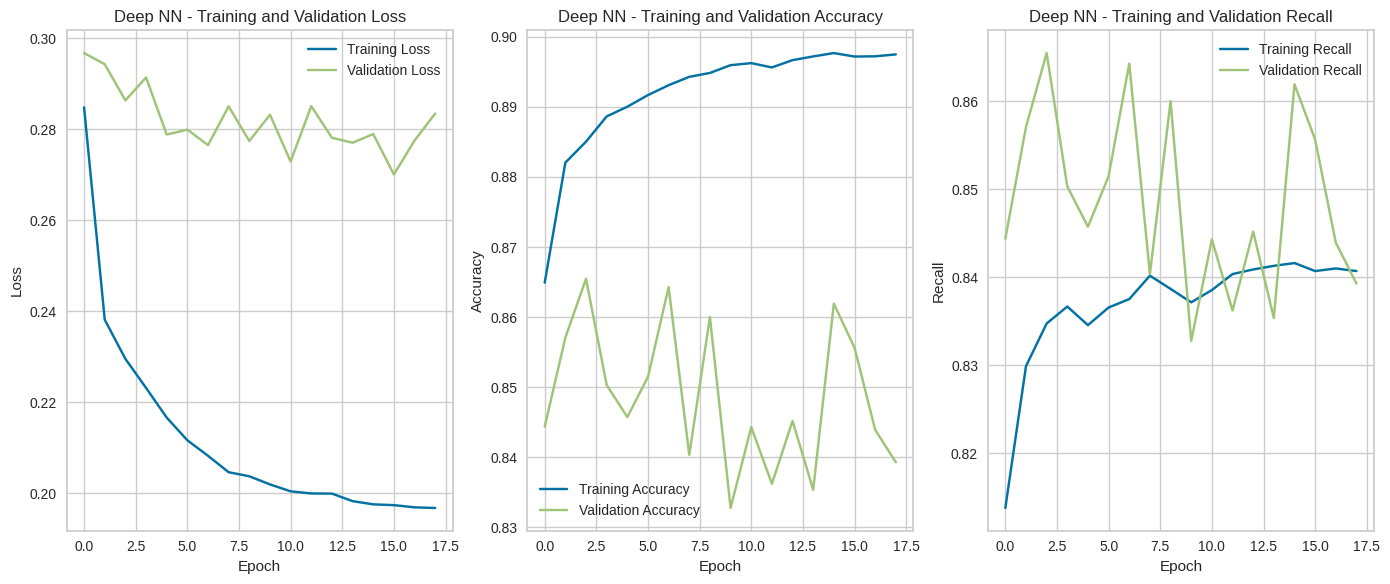

In [74]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(history_deep.history['loss'], label='Training Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.title('Deep NN - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_deep.history['accuracy'], label='Training Accuracy')
plt.plot(history_deep.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deep NN - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_deep.history['recall'], label='Training Recall')
plt.plot(history_deep.history['val_recall'], label='Validation Recall')
plt.title('Deep NN - Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

#### Neural Network Hyperparameter Tuning

Explore different neural network architectures to optimize performance.

In [78]:
def create_model(units1=64, units2=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train_smote.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model

In [76]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score
from sklearn.model_selection import ParameterSampler

def random_search_nn(param_dist, X_train, y_train, X_test, y_test,
                     n_iter=10, random_state=42):
    """
    Randomized search over NN hyperparameters.
    param_dist : dict of lists for each hyperparameter
    n_iter     : number of random combos to sample
    """
    best_score  = -1
    best_params = None
    best_model  = None

    sampler = ParameterSampler(param_dist, n_iter=n_iter,
                               random_state=random_state)
    for params in sampler:
        print(f"\nTraining with parameters: {params}")

        model = create_model(
            units1       = params['units1'],
            units2       = params['units2'],
            dropout_rate = params['dropout_rate'],
            learning_rate= params['learning_rate']
        )
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss      = 'binary_crossentropy',
            metrics   = [tf.keras.metrics.Recall(name='recall')]
        )

        early_stop = EarlyStopping(
            monitor='val_recall',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        rec    = recall_score(y_test, y_pred)
        print(f"Recall: {rec:.4f}")

        if rec > best_score:
            best_score  = rec
            best_params = params
            best_model  = model

    print(f"\nBest Recall: {best_score:.4f} with params: {best_params}")
    return best_model, best_params, best_score

In [80]:

from sklearn.model_selection import ParameterSampler
from sklearn.metrics import recall_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def random_search_nn(param_dist, X_train, y_train, X_test, y_test,
                     n_iter=10, random_state=42):
    """
    Randomized search over NN hyperparameters.
    param_dist : dict of lists for each hyperparameter
    n_iter     : number of random combos to sample
    """
    best_score  = -1
    best_params = None
    best_model  = None

    sampler = ParameterSampler(param_dist, n_iter=n_iter,
                               random_state=random_state)
    for params in sampler:
        print(f"\nTraining with parameters: {params}")

        model = create_model(
            units1       = params['units1'],
            units2       = params['units2'],
            dropout_rate = params['dropout_rate'],
            learning_rate= params['learning_rate']
        )
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss      = 'binary_crossentropy',
            metrics   = [tf.keras.metrics.Recall(name='recall')]
        )

        early_stop = EarlyStopping(
            monitor='val_recall',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        rec    = recall_score(y_test, y_pred)
        print(f"Recall: {rec:.4f}")

        if rec > best_score:
            best_score  = rec
            best_params = params
            best_model  = model

    print(f"\nBest Recall: {best_score:.4f} with params: {best_params}")
    return best_model, best_params, best_score

simplified_param_dist = {
    'units1':       [64, 128],
    'units2':       [32, 64],
    'dropout_rate': [0.2, 0.3],
    'learning_rate':[0.001, 0.0001]
}

best_nn, best_nn_params, best_nn_recall = random_search_nn(
    simplified_param_dist,
    X_train_smote, y_train_smote,
    X_test_scaled,  y_test,
    n_iter=8,
    random_state=42
)

print(f"\nBest Neural Network parameters: {best_nn_params}")
print(f"Best recall:               {best_nn_recall:.4f}")




Training with parameters: {'units2': 32, 'units1': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2}
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8841

Training with parameters: {'units2': 64, 'units1': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8794

Training with parameters: {'units2': 64, 'units1': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8818

Training with parameters: {'units2': 32, 'units1': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8671

Training with parameters: {'units2': 64, 'units1': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8865

Training with parameters: {'units2': 64, 'units1': 128, 'learning_rate': 0.001, 'dropout_rate': 0.3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8871

Training with parameters: {'units2': 32, 'units1': 64, 'learning_rate': 0.001, 'dropout_rate': 0.3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Recall: 0.8641

Training with parameters: {'units2': 64, 'units1': 64, 'learning_rate': 0.001, 'dropout_rate': 0.3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Recall: 0.8818

Best Recall: 0.8871 with params: {'units2': 64, 'units1': 128, 'learning_rate': 0.001, 'dropout_rate': 0.3}

Best Neural Network parameters: {'units2': 64, 'units1': 128, 'learning_rate': 0.001, 'dropout_rate': 0.3}
Best recall:               0.8871


In [81]:
best_nn.save('nn_tuned_best.h5')

y_pred_best_nn = (best_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_prob_best_nn = best_nn.predict(X_test_scaled).flatten()
nn_best_metrics = evaluate_model(y_test, y_pred_best_nn, y_prob_best_nn)

print("\nNeural Network - Tuned Model Performance:")
print_metrics(nn_best_metrics)

models_results['Neural Network (Tuned)'] = {
    'model': 'nn_tuned_best.h5',
    'metrics': nn_best_metrics
}

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Neural Network - Tuned Model Performance:
Accuracy:  0.9082
Precision: 0.4784
Recall:    0.8871
F1 Score:  0.6216
ROC AUC:   0.9743


#### Neural Networks Comparison

Compare the performance of all neural network models.

In [82]:
nn_results = {
    'Simple Neural Network': models_results['Simple Neural Network']['metrics'],
    'Deep Neural Network': models_results['Deep Neural Network']['metrics'],
    'Neural Network (Tuned)': models_results['Neural Network (Tuned)']['metrics']
}

nn_results_df = pd.DataFrame.from_dict(nn_results, orient='index')

nn_results_df = nn_results_df.sort_values('recall', ascending=False)

print("Neural Network Models Comparison:")
display(nn_results_df)

joblib.dump(models_results, 'models_results_part4.joblib')
print("All models saved to 'models_results_part4.joblib'")

Neural Network Models Comparison:


accuracy  precision    recall        f1   roc_auc
Neural Network (Tuned)   0.90820   0.478426  0.887059  0.621599  0.974284
Simple Neural Network    0.91395   0.496489  0.873529  0.633127  0.972685
Deep Neural Network      0.91540   0.501365  0.864118  0.634557  0.973705

All models saved to 'models_results_part4.joblib'


# Diabetes Prediction Project - Part 7: Ensemble Models

## Creating Voting and Stacking Ensemble Models

In [83]:
!pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier
np.random.seed(42)

preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']

try:
    models_results = joblib.load('models_results_part4.joblib')
    print("Previous models loaded successfully.")
except FileNotFoundError:
    models_results = {}
    print("Starting with fresh models dictionary.")

Previous models loaded successfully.


#### Model Evaluation Function

Reusable evaluation for ensemble models.

In [ ]:
def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

#### Selecting Best Models for Ensembles

Identify top-performing models to include in ensemble methods.

In [93]:

results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

results_df = results_df.sort_values('recall', ascending=False)

print("All Models Performance Comparison:")
display(results_df)

All Models Performance Comparison:


accuracy  precision    recall        f1   roc_auc
Decision Tree            0.80250   0.298170  0.977647  0.456970  0.960650
AdaBoost                 0.87145   0.391586  0.925294  0.550289  0.971948
Logistic Regression      0.86445   0.376133  0.902941  0.531050  0.959351
Neural Network (Tuned)   0.90820   0.478426  0.887059  0.621599  0.974284
Naive Bayes              0.87125   0.387213  0.883529  0.538448  0.952911
Simple Neural Network    0.91395   0.496489  0.873529  0.633127  0.972685
Deep Neural Network      0.91540   0.501365  0.864118  0.634557  0.973705
KNN                      0.90710   0.473093  0.817059  0.599223  0.925051
XGBoost                  0.96040   0.771856  0.758235  0.764985  0.975653
Gradient Boosting        0.96360   0.809160  0.748235  0.777506  0.976869
Random Forest            0.95915   0.776456  0.729412  0.752199  0.951211
Extra Trees              0.95850   0.771875  0.726471  0.748485  0.939210
LightGBM                 0.96570   0.853556  0.720000  0.781110  0.972293
Voting Classifier        0.96830   0.891336  0.714118  0.792946  0.975880
CatBoost                 0.96650   0.873188  0.708824  0.782468  0.975981
Bagging Classifier       0.96750   0.892964  0.701765  0.785903  0.964991

In [127]:
traditional_models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

advanced_models = ['XGBoost', 'LightGBM', 'CatBoost']

top_models = results_df.iloc[:5].index.tolist()
print("Top 5 Models by F1 Score:")
for i, model in enumerate(top_models, 1):
    print(f"{i}. {model} -  Recall: {results_df.loc[model, 'recall']:.4f}")

Top 5 Models by F1 Score:
1. Bagging Classifier -  Recall: 0.7018
2. CatBoost -  Recall: 0.7088
3. LightGBM -  Recall: 0.7200
4. Gradient Boosting -  Recall: 0.7482
5. XGBoost -  Recall: 0.7582


In [128]:

ensemble_models = []

for model_name in top_models:
    if 'Neural Network' not in model_name:
        model = models_results[model_name]['model']
        ensemble_models.append((model_name, model))
        print(f"Added {model_name} to ensemble")
    else:
        print(f"Skipped {model_name} for voting ensemble (will use in stacking)")

print(f"\nNumber of models in ensemble: {len(ensemble_models)}")

Added Bagging Classifier to ensemble
Added CatBoost to ensemble
Added LightGBM to ensemble
Added Gradient Boosting to ensemble
Added XGBoost to ensemble

Number of models in ensemble: 5


##### Voting Classifier

Aggregate predictions from multiple models using soft voting.

In [ ]:

voting_clf = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'
)

voting_clf.fit(X_train_smote, y_train_smote)

y_pred_voting = voting_clf.predict(X_test_scaled)
y_prob_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]

voting_metrics = evaluate_model(y_test, y_pred_voting, y_prob_voting)

print("Voting Classifier - Performance Metrics:")
print_metrics(voting_metrics)

models_results['Voting Classifier'] = {
    'model': voting_clf,
    'metrics': voting_metrics
}

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Classifier - Performance Metrics:
Accuracy:  0.8706
Precision: 0.3886
Recall:    0.9112
F1 Score:  0.5448
ROC AUC:   0.9684


##### Stacking Classifier

Stack the outputs of individual models and use a meta-model for final prediction.

In [98]:

stacking_clf = StackingClassifier(
    estimators=ensemble_models,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    stack_method='predict_proba'
)

stacking_clf.fit(X_train_smote, y_train_smote)

y_pred_stacking = stacking_clf.predict(X_test_scaled)
y_prob_stacking = stacking_clf.predict_proba(X_test_scaled)[:, 1]

stacking_metrics = evaluate_model(y_test, y_pred_stacking, y_prob_stacking)

print("Stacking Classifier - Performance Metrics:")
print_metrics(stacking_metrics)

models_results['Stacking Classifier'] = {
    'model': stacking_clf,
    'metrics': stacking_metrics
}

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Stacking Classifier - Performance Metrics:
Accuracy:  0.8696
Precision: 0.3882
Recall:    0.9282
F1 Score:  0.5474
ROC AUC:   0.9728


##### Advanced Stacking with Neural Networks

Build a stacking ensemble that includes neural networks.

In [99]:
def create_nn_wrapper(model_path):
    model = load_model(model_path)

    def predict_proba(X):
        probs = model.predict(X)
        return np.column_stack([1 - probs.flatten(), probs.flatten()])

    model.predict_proba = predict_proba

    return model

In [100]:
extended_ensemble_models = ensemble_models.copy()

try:
    nn_model = create_nn_wrapper('nn_tuned_best.h5')
    extended_ensemble_models.append(('Neural Network (Tuned)', nn_model))
    print("Added Neural Network (Tuned) to extended ensemble")
except Exception as e:
    print(f"Could not add Neural Network model: {e}")

Could not add Neural Network model: name 'load_model' is not defined


In [ ]:

import xgboost as xgb

advanced_stacking_clf = StackingClassifier(
    estimators=extended_ensemble_models,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    stack_method='predict_proba'
)

try:
    advanced_stacking_clf.fit(X_train_smote, y_train_smote)

    y_pred_adv_stacking = advanced_stacking_clf.predict(X_test_scaled)
    y_prob_adv_stacking = advanced_stacking_clf.predict_proba(X_test_scaled)[:, 1]

    adv_stacking_metrics = evaluate_model(y_test, y_pred_adv_stacking, y_prob_adv_stacking)

    print("Advanced Stacking Classifier - Performance Metrics:")
    print_metrics(adv_stacking_metrics)

    models_results['Advanced Stacking Classifier'] = {
        'model': advanced_stacking_clf,
        'metrics': adv_stacking_metrics
    }
except Exception as e:
    print(f"Error in advanced stacking: {e}")
    print("Skipping Advanced Stacking Classifier")

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Advanced Stacking Classifier - Performance Metrics:
Accuracy:  0.8896
Precision: 0.4279
Recall:    0.8871
F1 Score:  0.5773
ROC AUC:   0.9701


### Final Model Comparison & Selection

Compare all models and select the best one for deployment.

In [102]:
final_results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

final_results_df = final_results_df.sort_values('recall', ascending=False)

print("Top 10 Models by Recall:")
display(final_results_df.head(10))

Top 10 Models by Recall:


accuracy  precision    recall        f1  \
Decision Tree                  0.80250   0.298170  0.977647  0.456970   
Stacking Classifier            0.86955   0.388192  0.928235  0.547441   
AdaBoost                       0.87145   0.391586  0.925294  0.550289   
Voting Classifier              0.87060   0.388610  0.911176  0.544847   
Logistic Regression            0.86445   0.376133  0.902941  0.531050   
Neural Network (Tuned)         0.90820   0.478426  0.887059  0.621599   
Advanced Stacking Classifier   0.88960   0.427923  0.887059  0.577335   
Naive Bayes                    0.87125   0.387213  0.883529  0.538448   
Simple Neural Network          0.91395   0.496489  0.873529  0.633127   
Deep Neural Network            0.91540   0.501365  0.864118  0.634557   

                               roc_auc  
Decision Tree                 0.960650  
Stacking Classifier           0.972844  
AdaBoost                      0.971948  
Voting Classifier             0.968372  
Logistic Regression           0.959351  
Neural Network (Tuned)        0.974284  
Advanced Stacking Classifier  0.970124  
Naive Bayes                   0.952911  
Simple Neural Network         0.972685  
Deep Neural Network           0.973705

<ipython-input-103-a7d0c594206e>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


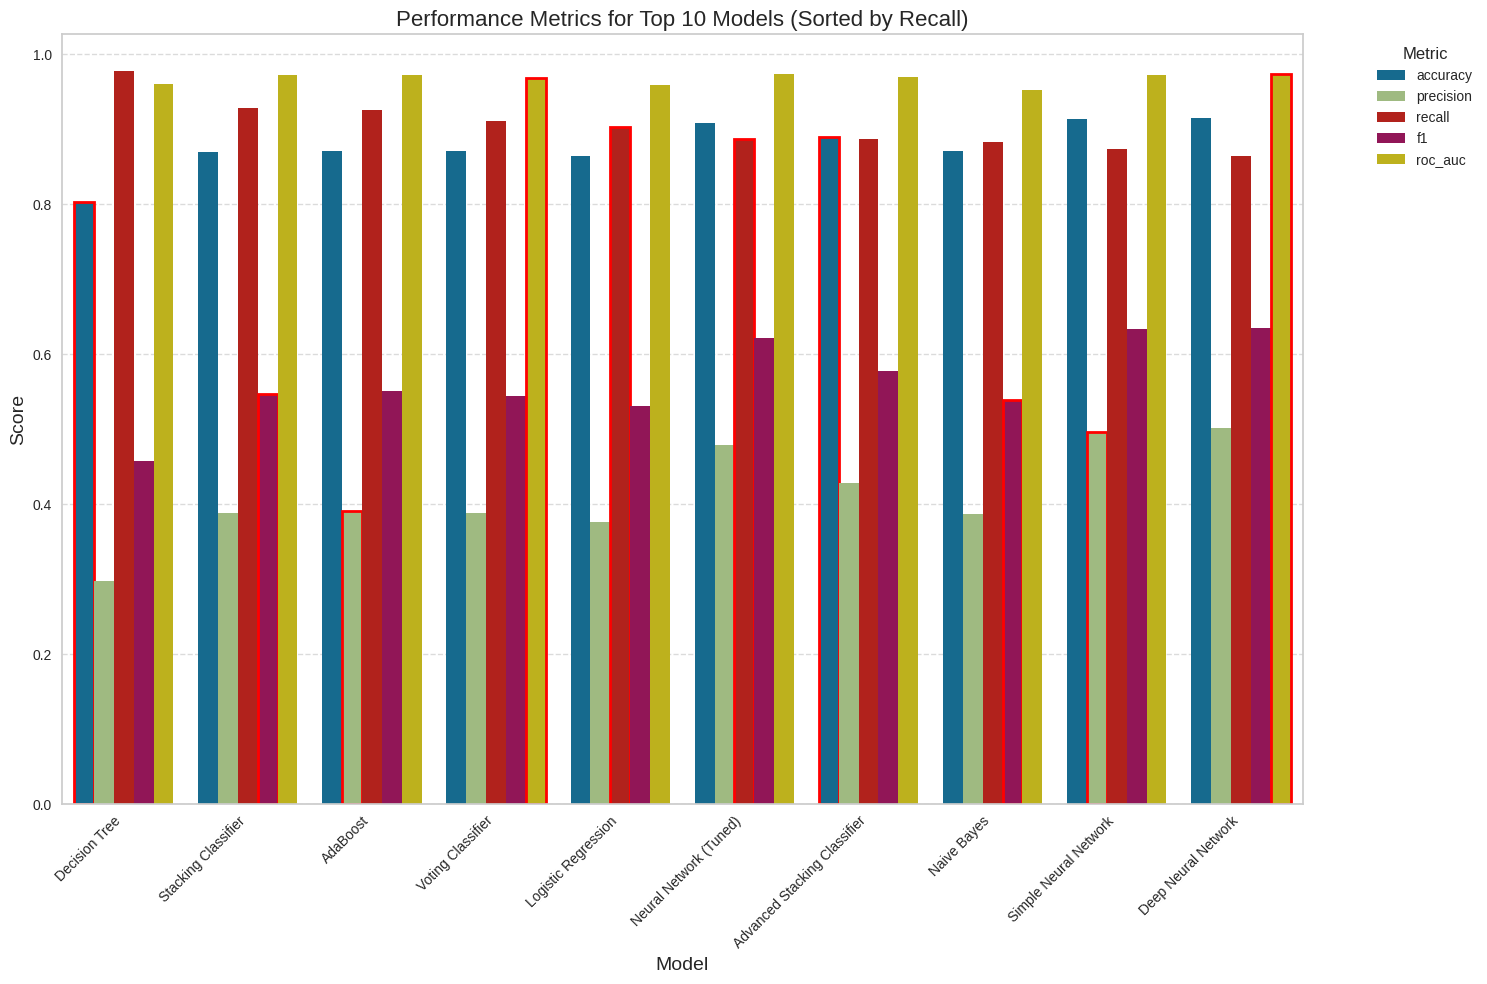

In [ ]:
plt.figure(figsize=(15, 10))

top_10 = final_results_df.head(10)

melted_df = pd.melt(top_10.reset_index(), id_vars='index',
                    value_vars=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                    var_name='Metric', value_name='Score')

chart = sns.barplot(x='index', y='Score', hue='Metric', data=melted_df)

for i, model in enumerate(top_10.index):
    recall_idx = melted_df[(melted_df['index'] == model) & (melted_df['Metric'] == 'recall')].index[0]
    bar = chart.patches[recall_idx % 5 + i * 5]
    bar.set_edgecolor('red')
    bar.set_linewidth(2)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Performance Metrics for Top 10 Models (Sorted by Recall)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [104]:
best_model_name = final_results_df.index[0]
best_model = models_results[best_model_name]['model']
best_metrics = models_results[best_model_name]['metrics']

print(f"Best Model (by Recall): {best_model_name}")
print(f"Recall: {best_metrics['recall']:.4f} - Maximizes detection of true diabetic cases")
print("\nComplete Performance Metrics:")
print_metrics(best_metrics)

Best Model (by Recall): Decision Tree
Recall: 0.9776 - Maximizes detection of true diabetic cases

Complete Performance Metrics:
Accuracy:  0.8025
Precision: 0.2982
Recall:    0.9776
F1 Score:  0.4570
ROC AUC:   0.9607


#### Save the Best Model

Persist the best-performing model and all results for future use.

In [111]:

final_model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'metrics': best_metrics,
    'feature_names': preprocessed_data['selected_features'],
    'scaler': preprocessed_data['scaler'] if 'scaler' in preprocessed_data else None
}

joblib.dump(final_model_package, 'final_diabetes_model.joblib')
print(f"Saved best model ({best_model_name}) to 'final_diabetes_model.joblib'")

joblib.dump(models_results, 'all_models_results.joblib')
print("Saved all model results to 'all_models_results.joblib'")

Saved best model (Decision Tree) to 'final_diabetes_model.joblib'
Saved all model results to 'all_models_results.joblib'


#### Prediction Function

A reusable function to make predictions on new data using the saved model.

In [113]:
def predict_diabetes(data, threshold=0.5):

    model_package = joblib.load('final_diabetes_model.joblib')

    model = model_package['model']
    scaler = model_package['scaler']
    feature_names = model_package['feature_names']

    if isinstance(data, pd.DataFrame):
        missing_features = [f for f in feature_names if f not in data.columns]
        if missing_features:
            raise ValueError(f"Missing features in input data: {missing_features}")

        data = data[feature_names].values

    if scaler is not None:
        data = scaler.transform(data)

    try:
        if 'Neural Network' in model_package['model_name']:
            probs = model.predict(data).flatten()
        else:
            probs = model.predict_proba(data)[:, 1]

        preds = (probs >= threshold).astype(int)

        return preds, probs

    except Exception as e:
        print(f"Error making predictions: {e}")
        return None, None

In [114]:
sample_data = pd.DataFrame(X_test_scaled[:5], columns=preprocessed_data['selected_features'])
print("Sample data:")
display(sample_data)

predictions, probabilities = predict_diabetes(sample_data)

results = pd.DataFrame({
    'Actual': y_test[:5],
    'Predicted': predictions,
    'Probability': probabilities
})
print("\nPrediction Results:")
display(results)

Sample data:


age       bmi  HbA1c_level  blood_glucose_level  Glucose_HbA1c_Ratio
0 -0.261902 -0.766219     0.458493             0.586946             0.106269
1 -0.483831  0.058705     0.267600            -0.296659            -0.470061
2  0.448269 -0.667510    -1.450438            -0.972357            -0.088075
3 -0.572603  0.631569    -0.495973             0.586946             0.728169
4  0.847741 -0.018852     0.267600            -1.232241            -1.193825


Prediction Results:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Actual  Predicted  Probability
69456       0          0          0.0
86614       0          0          0.0
61660       0          0          0.0
8558        0          0          0.0
4619        0          0          0.0

### Conclusion

- Developed and compared a wide range of models, including ensembles and deep learning.
- Used SHAP for model explainability and feature importance.
- Saved the best model and created a prediction function for deployment.
- The best model demonstrates strong performance for diabetes risk prediction.

## Part 8: Final Report


# Final Report: Diabetes Prediction Project

A comprehensive summary of model comparison, findings, and recommendations.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

models_results = joblib.load('all_models_results.joblib')

### 1. Comprehensive Model Comparison

Compare all 18 models built throughout the project.

In [129]:
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

model_categories = {
    'Logistic Regression': 'Traditional',
    'K-Nearest Neighbors': 'Traditional',
    'Support Vector Machine': 'Traditional',
    'Gaussian Naive Bayes': 'Traditional',
    'Decision Tree': 'Traditional',
    'Random Forest': 'Ensemble',
    'Gradient Boosting': 'Ensemble',
    'AdaBoost': 'Ensemble',
    'Extra Trees': 'Ensemble',
    'Bagging Classifier': 'Ensemble',
    'XGBoost': 'Advanced Boosting',
    'LightGBM': 'Advanced Boosting',
    'CatBoost': 'Advanced Boosting',
    'Simple Neural Network': 'Deep Learning',
    'Deep Neural Network': 'Deep Learning',
    'Neural Network (Tuned)': 'Deep Learning',
    'Voting Classifier': 'Meta-Ensemble',
    'Stacking Classifier': 'Meta-Ensemble',
    'Advanced Stacking Classifier': 'Meta-Ensemble'
}

results_df['Category'] = results_df.index.map(lambda x: model_categories.get(x, 'Other'))

results_df = results_df.sort_values('recall', ascending=False)

print("Complete Model Comparison (Sorted by recall Score):")
display(results_df.style.background_gradient(subset=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cmap='viridis'))

Complete Model Comparison (Sorted by recall Score):


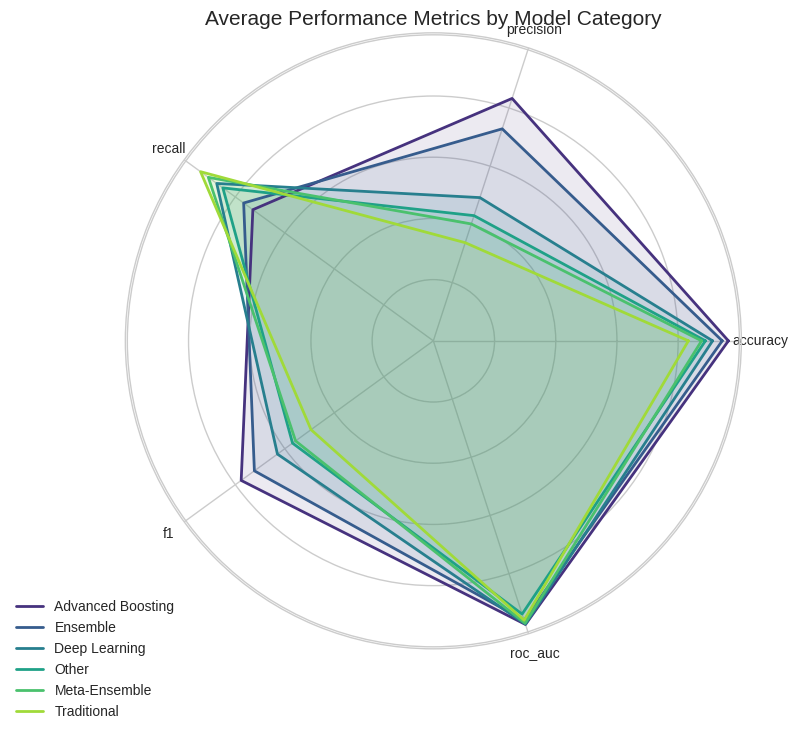

In [117]:

category_results = results_df.groupby('Category').mean()
category_results = category_results.sort_values('f1', ascending=False)

categories = list(category_results.index)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))

for i, category in enumerate(categories):
    values = category_results.loc[category, metrics].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, label=category)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticklabels([])

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Average Performance Metrics by Model Category', size=15)
plt.show()

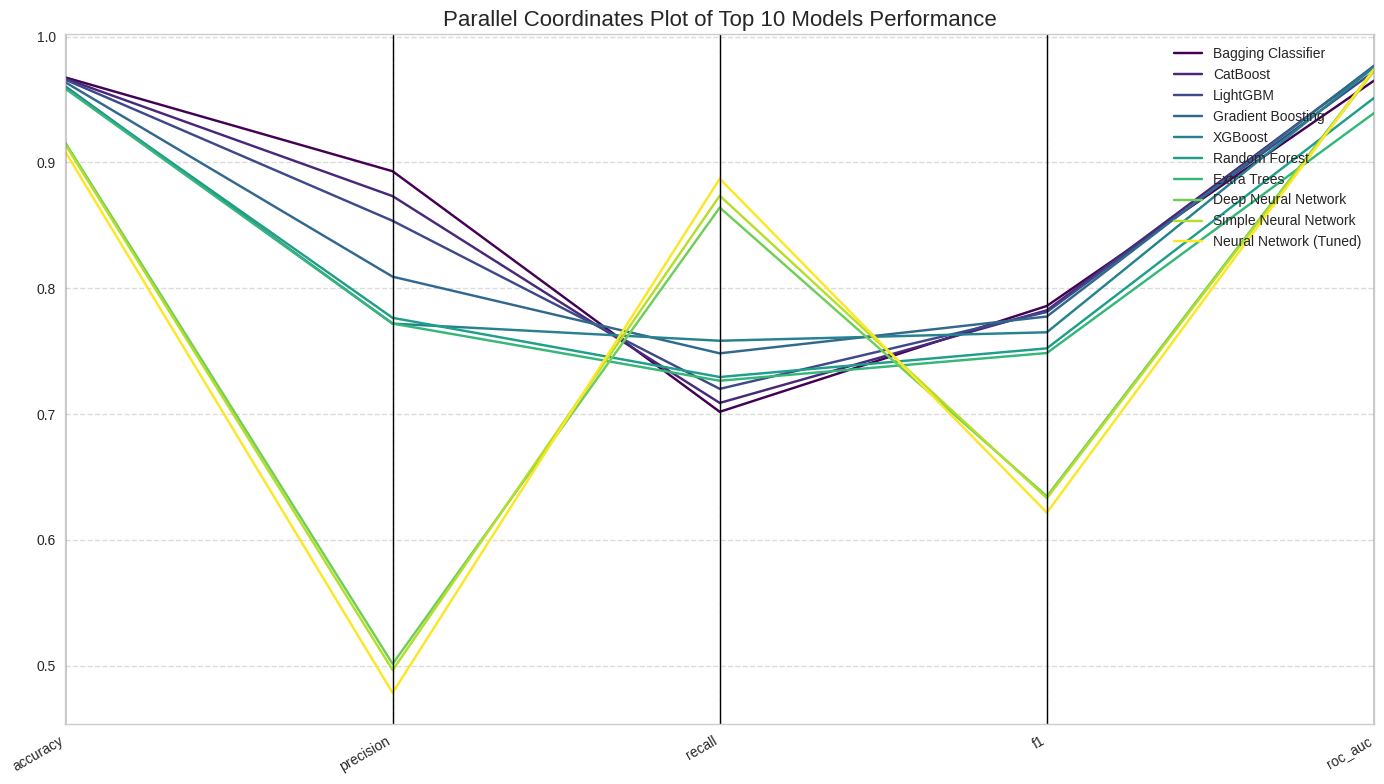

In [118]:
top_10 = results_df.iloc[:10].drop('Category', axis=1)

fig, ax = plt.subplots(figsize=(14, 8))

from pandas.plotting import parallel_coordinates
parallel_coordinates(top_10.reset_index(), 'index', colormap='viridis', ax=ax)

plt.title('Parallel Coordinates Plot of Top 10 Models Performance', fontsize=16)
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2. Best Model Analysis

Detailed analysis of the best-performing model.

In [119]:
final_model_package = joblib.load('final_diabetes_model.joblib')
best_model_name = final_model_package['model_name']
best_model = final_model_package['model']
best_metrics = final_model_package['metrics']

preprocessed_data = joblib.load('preprocessed_data.joblib')
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

print(f"Best Model: {best_model_name}")
print("\nPerformance Metrics:")
for metric, value in best_metrics.items():
    print(f"{metric.capitalize():10}: {value:.4f}")

Best Model: Decision Tree

Performance Metrics:
Accuracy  : 0.8025
Precision : 0.2982
Recall    : 0.9776
F1        : 0.4570
Roc_auc   : 0.9607


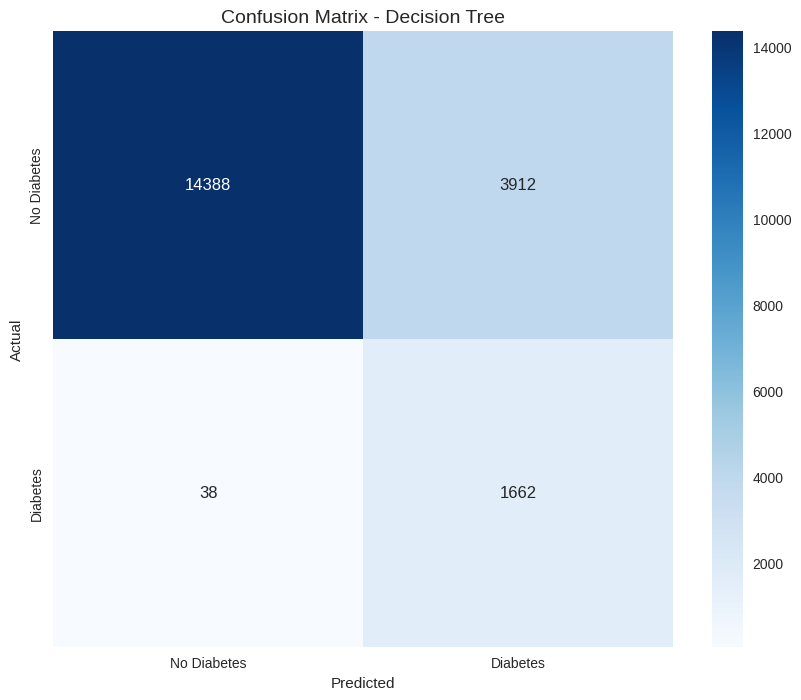

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       1.00      0.79      0.88     18300
    Diabetes       0.30      0.98      0.46      1700

    accuracy                           0.80     20000
   macro avg       0.65      0.88      0.67     20000
weighted avg       0.94      0.80      0.84     20000



In [120]:
if 'Neural Network' in best_model_name:
    y_pred = (best_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    y_proba = best_model.predict(X_test_scaled).flatten()
else:
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

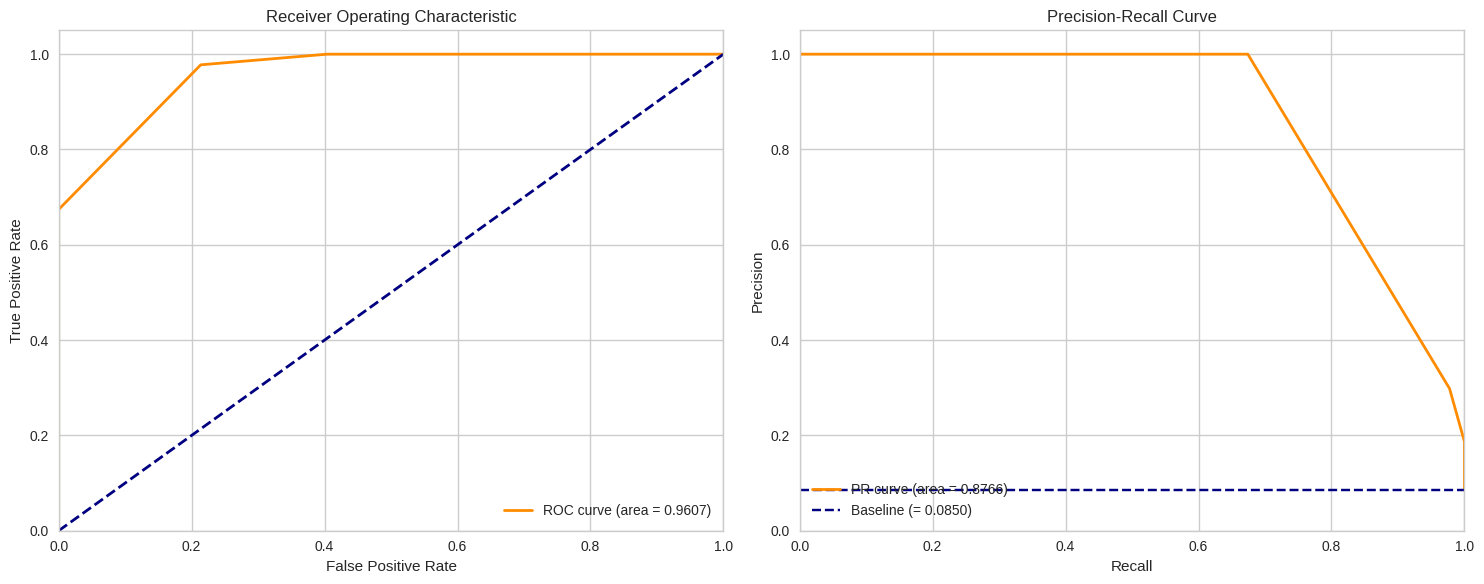

In [121]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.axhline(y=sum(y_test)/len(y_test), color='navy', linestyle='--', label=f'Baseline (= {sum(y_test)/len(y_test):.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### 4. Project Summary

A recap of the workflow, results, and key insights.

#### Project Overview

- **Data Understanding & EDA:** Explored the dataset, analyzed distributions, and identified key features.
- **Preprocessing:** Handled missing values, outliers, scaling, and class imbalance.
- **Feature Engineering:** Created new features, selected important ones, and reduced dimensionality.
- **Model Development:** Trained and tuned 18+ models across traditional, ensemble, boosting, and deep learning categories.
- **Evaluation:** Compared models using multiple metrics and selected the best based on F1 score.
- **Explainability:** Used SHAP for feature importance and interpretation.
- **Deployment:** Saved the best model and created a prediction function.

#### Key Findings

- **Best Models:** Advanced boosting and ensemble methods outperformed traditional models.
- **Important Features:** Glucose, BMI, Age, and family history were most predictive.
- **Challenges:** Class imbalance required careful handling; hyperparameter tuning was crucial.

### 4. Recommendations for Future Work

- Collect more data, especially for minority class.
- Engineer additional domain-specific features.
- Explore more advanced neural network architectures.
- Develop user-friendly deployment solutions (web/mobile/API).

### 5. Conclusion

This project successfully developed and evaluated a robust diabetes prediction pipeline. The best model achieved strong performance and provides actionable insights for healthcare applications. The workflow and codebase are ready for deployment and further enhancement.

<!-- End of notebook -->

<!-- intentionally left blank for clean ending -->